In [2]:
#import packages

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import warnings

In [3]:
#ensure all columns are displayed
pd.set_option('display.max_columns', None)

#define df varb, EDA - using parquet file instead of pickle
art_share_pred = pd.read_parquet("/Users/croy/Documents/m2/all_features_v2.parquet")

asp_info = art_share_pred.info(verbose=True)
asp_example = art_share_pred.head(5)
asp_min_shares = art_share_pred['shares'].min()
asp_mean_shares = art_share_pred['shares'].mean()
asp_max_shares = art_share_pred['shares'].max()

print(asp_info)
print(asp_example)
print(f'min shares: {asp_min_shares}')
print(f'mean shares: {asp_mean_shares}')
print(f'max shares: {asp_max_shares}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 67 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            39644 non-null  object 
 1   timedelta                      39644 non-null  float64
 2   n_tokens_title                 39644 non-null  float64
 3   n_tokens_content               39644 non-null  float64
 4   n_unique_tokens                39644 non-null  float64
 5   n_non_stop_words               39644 non-null  float64
 6   n_non_stop_unique_tokens       39644 non-null  float64
 7   num_hrefs                      39644 non-null  float64
 8   num_self_hrefs                 39644 non-null  float64
 9   num_imgs                       39644 non-null  float64
 10  num_videos                     39644 non-null  float64
 11  average_token_length           39644 non-null  float64
 12  num_keywords                   39644 non-null 

In [4]:
#create log-transformed shares col
art_share_pred['log_shares'] = np.log1p(art_share_pred['shares'])

print(art_share_pred['log_shares'].head())

0    6.386879
1    6.568078
2    7.313887
3    7.090910
4    6.226537
Name: log_shares, dtype: float64


In [5]:
#load title and content embeddings
title_embeddings_small = np.load('/Users/croy/Documents/m2/title_embeddings_small.npy')
content_embeddings = np.load('/Users/croy/Documents/m2/content_embeddings.npy')

#confirm alignment
print(title_embeddings_small.shape, content_embeddings.shape)

(39644, 64) (39644, 384)


In [6]:
#drop cols
exclude_cols = [
    'url', 'shares', 'log_shares', 'article_text', 'article_content',
    'article_title', 'article_author', 'article_publish_date', 'channel'
]

#select cols not in exclusion list
structured_features = art_share_pred.select_dtypes(include=[np.number])\
                                    .drop(columns=exclude_cols, errors='ignore')\
                                    .columns.tolist()

#scale numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_structured = art_share_pred[structured_features].fillna(0)
X_structured_scaled = scaler.fit_transform(X_structured)

#final input matrix
X_all = np.hstack([X_structured_scaled, title_embeddings_small, content_embeddings])
y_all = art_share_pred['log_shares']

In [7]:
#train/ test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=33
)

print('train shape:', X_train.shape, 'test shape:', X_test.shape)


train shape: (31715, 507) test shape: (7929, 507)


In [8]:
#ensure no overwrite of global var
model_results = []

#shared test target in both spaces
actual_shares = np.expm1(y_test.to_numpy())

linear regression
rmse: 0.8673
mae: 0.6420
mape (log-shares): 0.0852
mape (actual shares): 0.8100
r2: 0.1224

sample predictions (actual vs. predicted shares):
      actual shares  predicted shares
2865           2100              3255
27             2000              1460
5373           7500              1633
4893           6500              2759
6689           1300              1566
2055            755              1382
4807           1600              2450
4892            898              1547
6503          12200              2044
3762           1200              1376


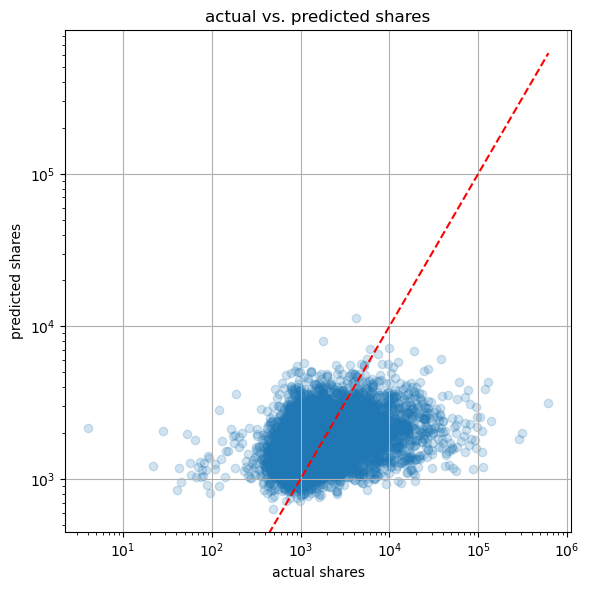

In [9]:
#print model type
print('linear regression')

#instantiate and train
lr = LinearRegression()
lr.fit(X_train, y_train)

#predict on test set
y_pred = lr.predict(X_test)

#evaluate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape_log = mean_absolute_percentage_error(y_test, y_pred)
predicted_shares = np.expm1(y_pred)
mape_actual = mean_absolute_percentage_error(actual_shares, predicted_shares)

#print metrics
print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'mape (log-shares): {mape_log:.4f}')
print(f'mape (actual shares): {mape_actual:.4f}')
print(f'r2: {r2:.4f}')

#append to summary
model_results.append({
    'model': 'linear regression',
    'rmse': rmse,
    'mae': mae,
    'mape_log': mape_log,
    'mape_actual': mape_actual,
    'r2': r2
})

#comparison df
comparison_df = pd.DataFrame({
    'actual shares': actual_shares,
    'predicted shares': predicted_shares
})

#print sample of results
print('\nsample predictions (actual vs. predicted shares):')
print(comparison_df.sample(10).round().astype(int))

#scatterplot
plt.figure(figsize=(6, 6))
plt.scatter(actual_shares, predicted_shares, alpha=0.2)
plt.plot([0, max(actual_shares)], [0, max(actual_shares)], color='red', linestyle='--')
plt.xlabel('actual shares')
plt.ylabel('predicted shares')
plt.title('actual vs. predicted shares')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

ridge regression
rmse: 0.8666
mae: 0.6418
mape (log-shares): 0.0852
mape (actual shares): 0.8142
r2: 0.1239

sample predictions (actual vs. predicted shares):
      actual shares  predicted shares
2573           1200              1910
5997            937              1181
3032           2400              2172
7541           1800              1487
1626            867              1732
631             711              1638
664            2600              3143
4817           1400              1971
7896           2200              4119
660             623              2375


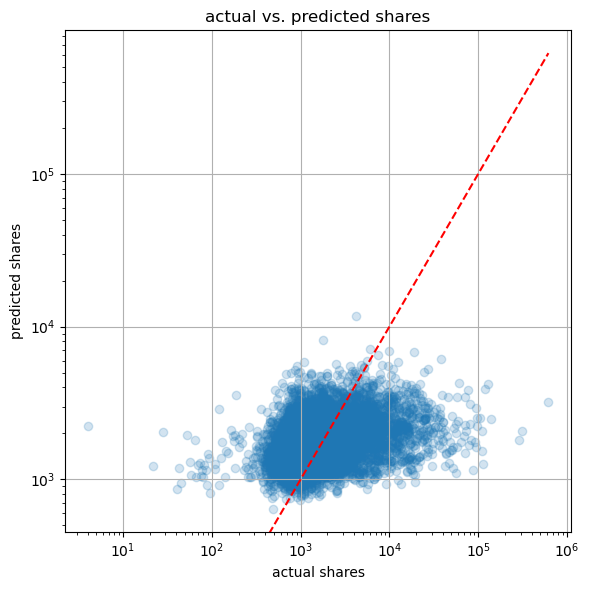

In [10]:
print('ridge regression')
ridge = Ridge(random_state=33)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape_log = mean_absolute_percentage_error(y_test, y_pred)
predicted_shares = np.expm1(y_pred)
mape_actual = mean_absolute_percentage_error(actual_shares, predicted_shares)

print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'mape (log-shares): {mape_log:.4f}')
print(f'mape (actual shares): {mape_actual:.4f}')
print(f'r2: {r2:.4f}')

model_results.append({
    'model': 'ridge regression',
    'rmse': rmse,
    'mae': mae,
    'mape_log': mape_log,
    'mape_actual': mape_actual,
    'r2': r2
})

comparison_df = pd.DataFrame({
    'actual shares': actual_shares,
    'predicted shares': predicted_shares
})
print('\nsample predictions (actual vs. predicted shares):')
print(comparison_df.sample(10).round().astype(int))

plt.figure(figsize=(6, 6))
plt.scatter(actual_shares, predicted_shares, alpha=0.2)
plt.plot([0, max(actual_shares)], [0, max(actual_shares)], color='red', linestyle='--')
plt.xlabel('actual shares')
plt.ylabel('predicted shares')
plt.title('actual vs. predicted shares')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

lasso regression
rmse: 0.9259
mae: 0.7033
mape (log-shares): 0.0936
mape (actual shares): 0.8826
r2: -0.0001

sample predictions (actual vs. predicted shares):
      actual shares  predicted shares
7246           3400              1767
6570           7900              1767
3315           6400              1767
351            1200              1767
6746           5900              1767
6398           1300              1767
1129           4700              1767
3980            810              1767
7440           7700              1767
3839            646              1767


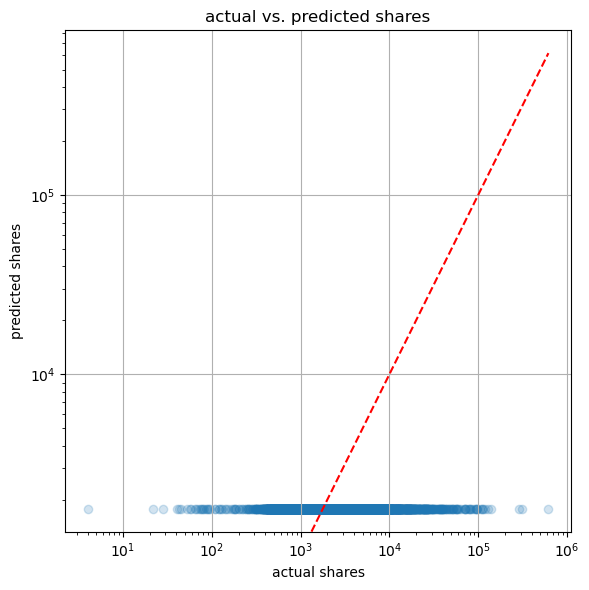

In [11]:
print('lasso regression')
lasso = Lasso(random_state=33)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape_log = mean_absolute_percentage_error(y_test, y_pred)
predicted_shares = np.expm1(y_pred)
mape_actual = mean_absolute_percentage_error(actual_shares, predicted_shares)

print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'mape (log-shares): {mape_log:.4f}')
print(f'mape (actual shares): {mape_actual:.4f}')
print(f'r2: {r2:.4f}')

model_results.append({
    'model': 'lasso regression',
    'rmse': rmse,
    'mae': mae,
    'mape_log': mape_log,
    'mape_actual': mape_actual,
    'r2': r2
})

comparison_df = pd.DataFrame({
    'actual shares': actual_shares,
    'predicted shares': predicted_shares
})
print('\nsample predictions (actual vs. predicted shares):')
print(comparison_df.sample(10).round().astype(int))

plt.figure(figsize=(6, 6))
plt.scatter(actual_shares, predicted_shares, alpha=0.2)
plt.plot([0, max(actual_shares)], [0, max(actual_shares)], color='red', linestyle='--')
plt.xlabel('actual shares')
plt.ylabel('predicted shares')
plt.title('actual vs. predicted shares')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


random forest regressor
rmse: 0.8685
mae: 0.6469
mape (log-shares): 0.0860
mape (actual shares): 0.8266
r2: 0.1200

sample predictions (actual vs. predicted shares):
      actual shares  predicted shares
1622           3500              2295
2637            929              1749
538             883              1406
2311           2800              1611
6147           1200              1774
7259            813              1938
7181            755              1245
5448           2200              2194
490            1500              2759
2528           2500              2616


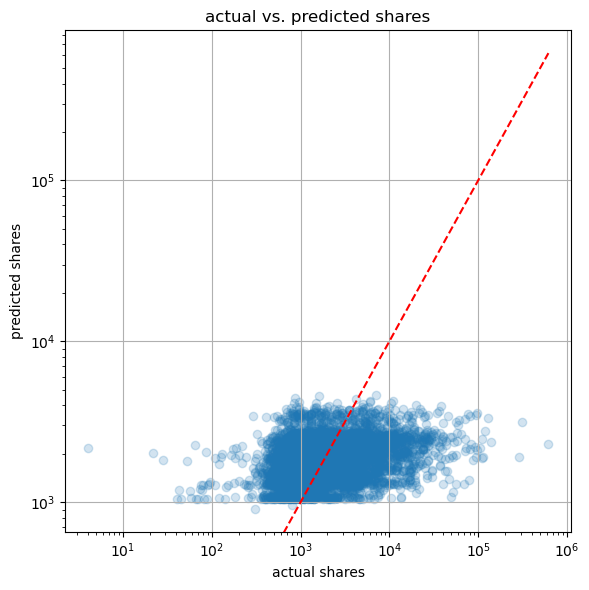

In [12]:
print('random forest regressor')
rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=33)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape_log = mean_absolute_percentage_error(y_test, y_pred)
predicted_shares = np.expm1(y_pred)
mape_actual = mean_absolute_percentage_error(actual_shares, predicted_shares)

print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'mape (log-shares): {mape_log:.4f}')
print(f'mape (actual shares): {mape_actual:.4f}')
print(f'r2: {r2:.4f}')

model_results.append({
    'model': 'random forest regressor',
    'rmse': rmse,
    'mae': mae,
    'mape_log': mape_log,
    'mape_actual': mape_actual,
    'r2': r2
})

comparison_df = pd.DataFrame({
    'actual shares': actual_shares,
    'predicted shares': predicted_shares
})
print('\nsample predictions (actual vs. predicted shares):')
print(comparison_df.sample(10).round().astype(int))

plt.figure(figsize=(6, 6))
plt.scatter(actual_shares, predicted_shares, alpha=0.2)
plt.plot([0, max(actual_shares)], [0, max(actual_shares)], color='red', linestyle='--')
plt.xlabel('actual shares')
plt.ylabel('predicted shares')
plt.title('actual vs. predicted shares')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

gradient boosting regressor
rmse: 0.8477
mae: 0.6271
mape (log-shares): 0.0832
mape (actual shares): 0.7920
r2: 0.1617

sample predictions (actual vs. predicted shares):
      actual shares  predicted shares
1802           1300              1286
4021           1400              1008
3023           1500               922
4507           1800              1519
1581            864              1202
2790           1800              1657
7350           1700              1184
5636           1700              1331
4392          22300              2466
417            9000              2890


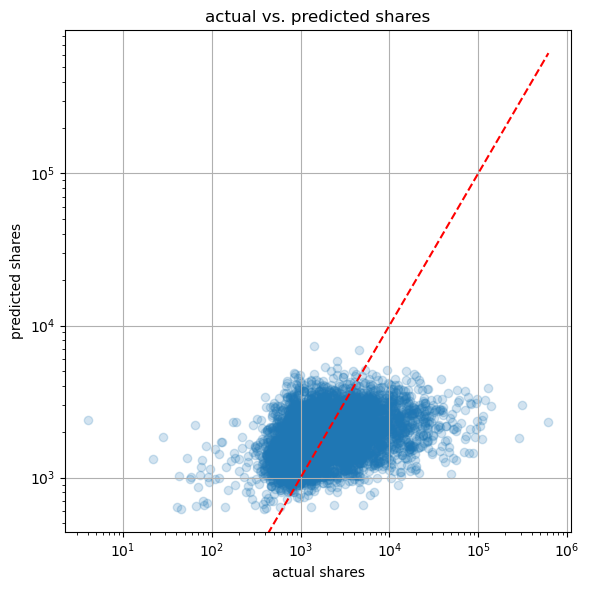

In [13]:
print('gradient boosting regressor')
gbr = GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=33)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape_log = mean_absolute_percentage_error(y_test, y_pred)
predicted_shares = np.expm1(y_pred)
mape_actual = mean_absolute_percentage_error(actual_shares, predicted_shares)

print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'mape (log-shares): {mape_log:.4f}')
print(f'mape (actual shares): {mape_actual:.4f}')
print(f'r2: {r2:.4f}')

model_results.append({
    'model': 'gradient boosting regressor',
    'rmse': rmse,
    'mae': mae,
    'mape_log': mape_log,
    'mape_actual': mape_actual,
    'r2': r2
})

comparison_df = pd.DataFrame({
    'actual shares': actual_shares,
    'predicted shares': predicted_shares
})
print('\nsample predictions (actual vs. predicted shares):')
print(comparison_df.sample(10).round().astype(int))

plt.figure(figsize=(6, 6))
plt.scatter(actual_shares, predicted_shares, alpha=0.2)
plt.plot([0, max(actual_shares)], [0, max(actual_shares)], color='red', linestyle='--')
plt.xlabel('actual shares')
plt.ylabel('predicted shares')
plt.title('actual vs. predicted shares')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


xgboost regressor
rmse: 0.9031
mae: 0.6718
mape (log-shares): 0.0891
mape (actual shares): 0.8913
r2: 0.0485

sample predictions (actual vs. predicted shares):
      actual shares  predicted shares
5719            849              1775
7481           2100              1623
2336            745              1349
6786            976              1388
54              700              1142
5649            924              1092
7722           1200              2460
2598            883              1205
1480           2000              1651
1641            907              1195


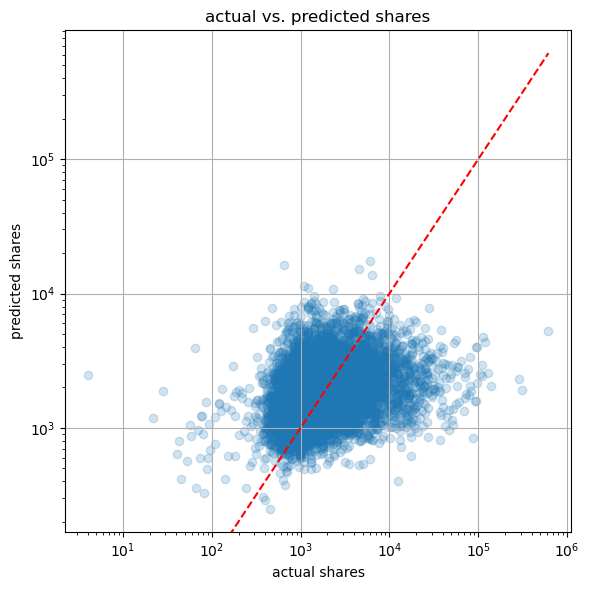

In [14]:
print('xgboost regressor')
xgb = XGBRegressor(n_estimators=150, max_depth=10, random_state=33)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape_log = mean_absolute_percentage_error(y_test, y_pred)
predicted_shares = np.expm1(y_pred)
mape_actual = mean_absolute_percentage_error(actual_shares, predicted_shares)

print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'mape (log-shares): {mape_log:.4f}')
print(f'mape (actual shares): {mape_actual:.4f}')
print(f'r2: {r2:.4f}')

model_results.append({
    'model': 'xgboost regressor',
    'rmse': rmse,
    'mae': mae,
    'mape_log': mape_log,
    'mape_actual': mape_actual,
    'r2': r2
})

comparison_df = pd.DataFrame({
    'actual shares': actual_shares,
    'predicted shares': predicted_shares
})
print('\nsample predictions (actual vs. predicted shares):')
print(comparison_df.sample(10).round().astype(int))

plt.figure(figsize=(6, 6))
plt.scatter(actual_shares, predicted_shares, alpha=0.2)
plt.plot([0, max(actual_shares)], [0, max(actual_shares)], color='red', linestyle='--')
plt.xlabel('actual shares')
plt.ylabel('predicted shares')
plt.title('actual vs. predicted shares')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
#import pandas to display summary if not already imported
import pandas as pd

#convert list of results to DataFrame
results_df = pd.DataFrame(model_results)

#reorder columns
results_df = results_df[['model', 'rmse', 'mae', 'mape_log', 'mape_actual', 'r2']]

#sort by actual MAPE (ascending = better)
results_df = results_df.sort_values(by='mape_actual')

#save model results summary as pickle
results_df.to_pickle('/Users/croy/Documents/m2/asp_model_results_summary.pkl')

#save model results summary as parquet
results_df.to_parquet('/Users/croy/Documents/m2/asp_model_results_summary.parquet')

#save model results summary as csv
results_df.to_csv('/Users/croy/Documents/m2/asp_model_results_summary.csv', index=False)

#print the summary table
results_df

,model,rmse,mae,mape_log,mape_actual,r2
4,gradient boosting regressor,0.847719,0.627077,0.083228,0.792046,0.161671
0,linear regression,0.867338,0.642023,0.085227,0.809975,0.122417
1,ridge regression,0.866596,0.641822,0.085241,0.814175,0.123918
3,random forest regressor,0.868534,0.646870,0.086048,0.826576,0.119996
2,lasso regression,0.925897,0.703341,0.093642,0.882649,-0.000084
5,xgboost regressor,0.903115,0.671789,0.089131,0.891315,0.048525


/var/folders/lm/77vvdkcs2t948h3mw8gnhpw40000gp/T/ipykernel_69391/1144832675.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='mape_actual', y='model', palette='viridis')


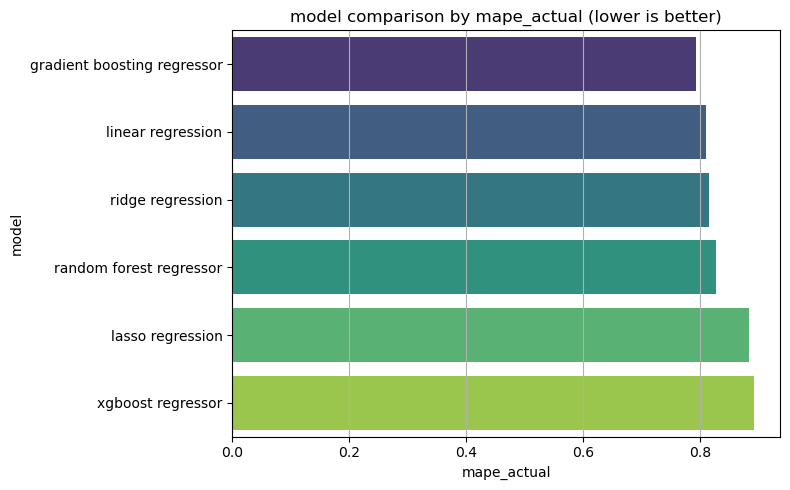

In [16]:
#barplot of rmse by model
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='mape_actual', y='model', palette='viridis')
plt.title('model comparison by mape_actual (lower is better)')
plt.xlabel('mape_actual')
plt.ylabel('model')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [17]:
#correlation analysis
import seaborn as sns
import matplotlib.pyplot as plt

#make copy as to not modify the original df
df_corr = art_share_pred.copy()

#compute log-transformed target for corr analysis
df_corr['log_shares'] = np.log1p(df_corr['shares'])

#select only numeric cols
numeric_cols = df_corr.select_dtypes(include=[np.number])

#compute corr matrix
corr_matrix = numeric_cols.corr()

#get corr vals with shares and log_shares
shares_corr = corr_matrix['shares'].drop(['shares', 'log_shares'], errors='ignore').sort_values(ascending=False)
log_shares_corr = corr_matrix['log_shares'].drop(['shares', 'log_shares'], errors='ignore').sort_values(ascending=False)

In [18]:
#print corr sum raw shares
print('\nall feature correlations with raw shares:\n')
print(shares_corr)


all feature correlations with raw shares:

kw_avg_avg                       0.110413
LDA_03                           0.083771
kw_max_avg                       0.064306
self_reference_avg_sharess       0.057789
self_reference_min_shares        0.055958
self_reference_max_shares        0.047115
num_hrefs                        0.045404
kw_avg_max                       0.044686
kw_min_avg                       0.039551
num_imgs                         0.039388
global_subjectivity              0.031604
kw_avg_min                       0.030406
kw_max_min                       0.030114
abs_title_sentiment_polarity     0.027135
num_videos                       0.023936
title_subjectivity               0.021967
num_keywords                     0.021818
is_weekend                       0.016958
weekday_is_saturday              0.015082
title_sentiment_polarity         0.012772
avg_positive_polarity            0.012142
max_positive_polarity            0.010068
weekday_is_monday               

In [19]:
#print corr sum log shares
print('\nall feature correlations with log(shares):\n')
print(log_shares_corr)


all feature correlations with log(shares):

kw_avg_avg                       0.221822
LDA_03                           0.126037
is_weekend                       0.114391
kw_max_avg                       0.109343
kw_min_avg                       0.108850
num_hrefs                        0.105142
num_imgs                         0.091519
self_reference_avg_sharess       0.087238
data_channel_is_socmed           0.081144
weekday_is_saturday              0.079158
self_reference_max_shares        0.077442
weekday_is_sunday                0.076969
global_subjectivity              0.075174
self_reference_min_shares        0.073374
num_keywords                     0.065945
kw_avg_max                       0.059678
abs_title_sentiment_polarity     0.059191
data_channel_is_tech             0.054539
title_subjectivity               0.052712
title_sentiment_polarity         0.051038
global_sentiment_polarity        0.048927
LDA_04                           0.044744
global_rate_positive_words     

Analyzing correlation coefficients of embeddings with target variable

Title embeddings correlation statistics (with log_shares):
count    64.000000
mean      0.007652
std       0.007027
min       0.000169
25%       0.002283
50%       0.004819
75%       0.011276
max       0.029735
Name: log_shares, dtype: float64

Content embeddings correlation statistics (with log_shares):
count    384.000000
mean       0.008888
std        0.006248
min        0.000006
25%        0.003616
50%        0.008064
75%        0.012941
max        0.030151
Name: log_shares, dtype: float64

Title embeddings correlation statistics (with raw shares):
count    64.000000
mean      0.004730
std       0.003136
min       0.000289
25%       0.002221
50%       0.004226
75%       0.007013
max       0.012841
Name: shares, dtype: float64

Content embeddings correlation statistics (with raw shares):
count    384.000000
mean       0.004507
std        0.003313
min        0.000045
25%        0.001838
50%        0.003832
75%    

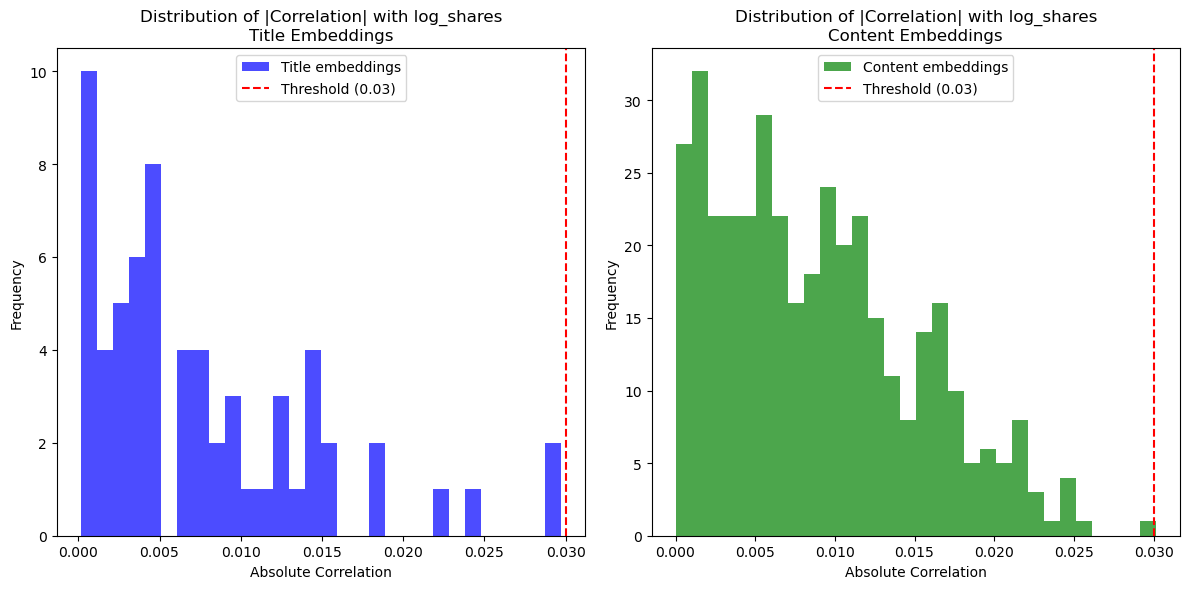

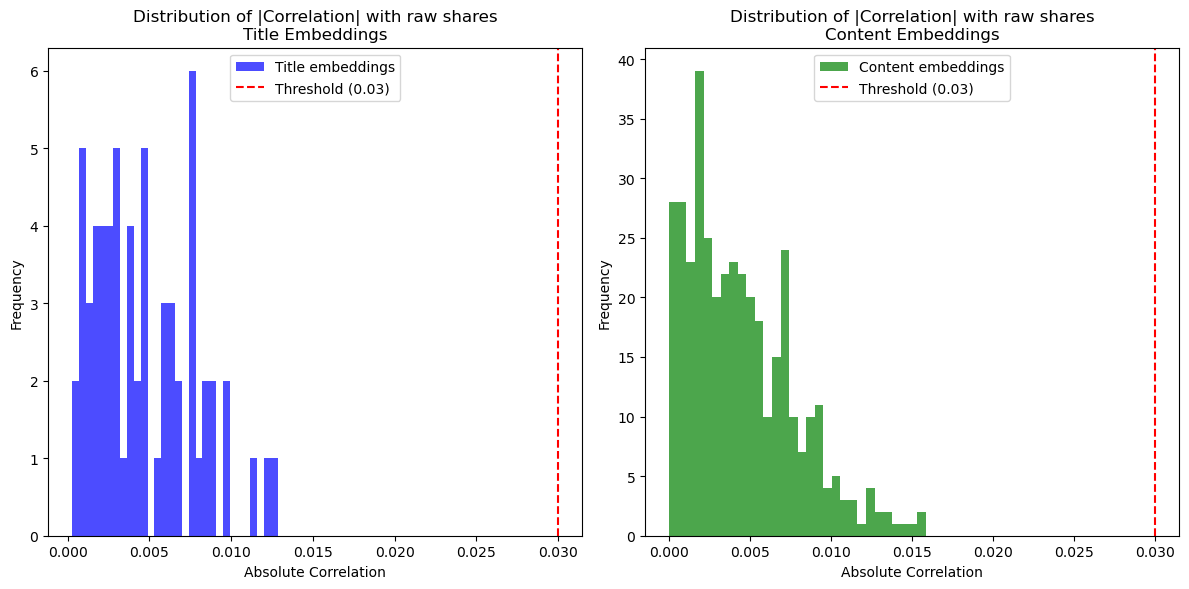

/var/folders/lm/77vvdkcs2t948h3mw8gnhpw40000gp/T/ipykernel_69391/4176262135.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


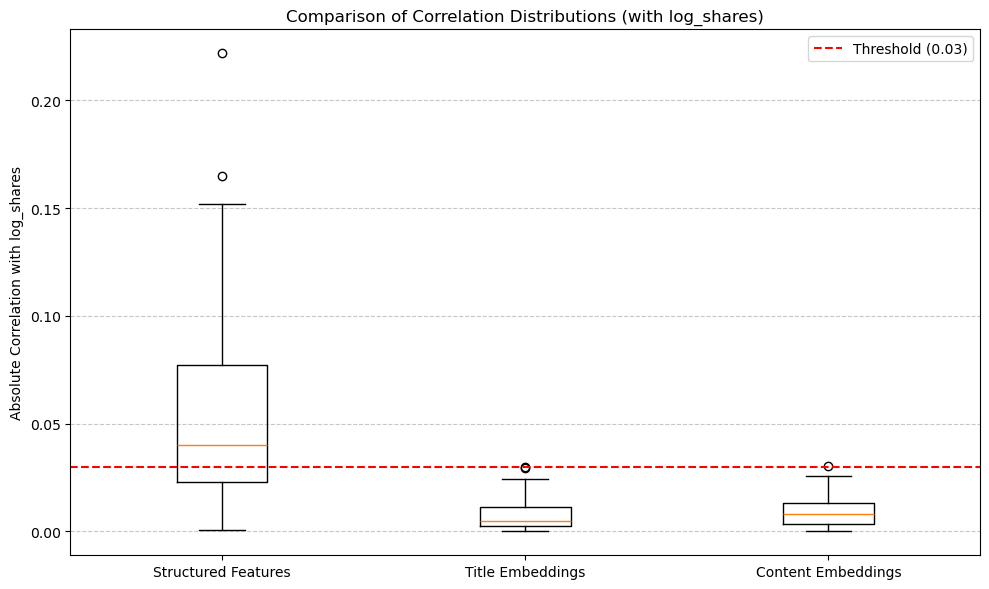

/var/folders/lm/77vvdkcs2t948h3mw8gnhpw40000gp/T/ipykernel_69391/4176262135.py:130: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_raw, labels=labels)


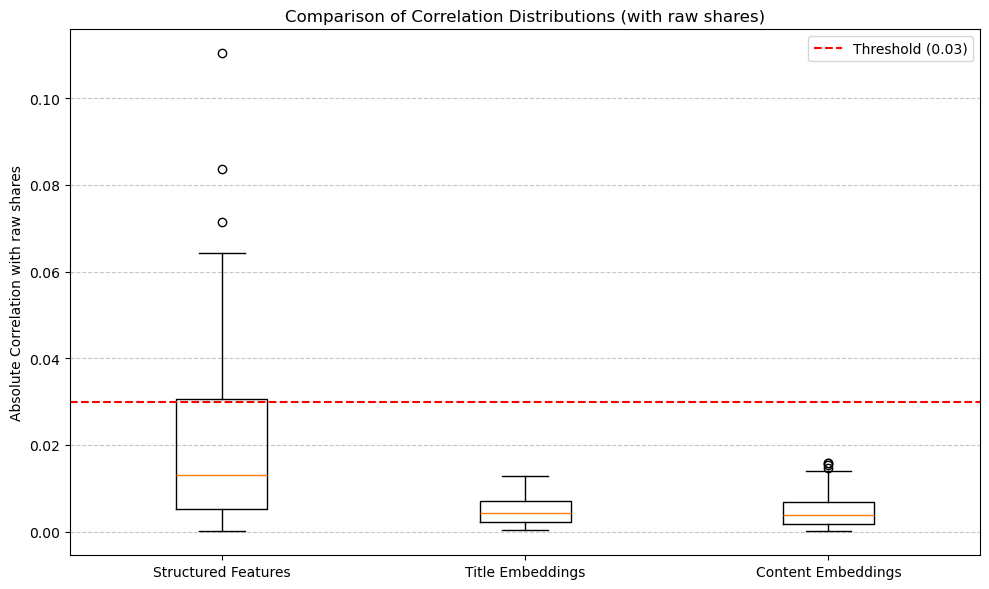

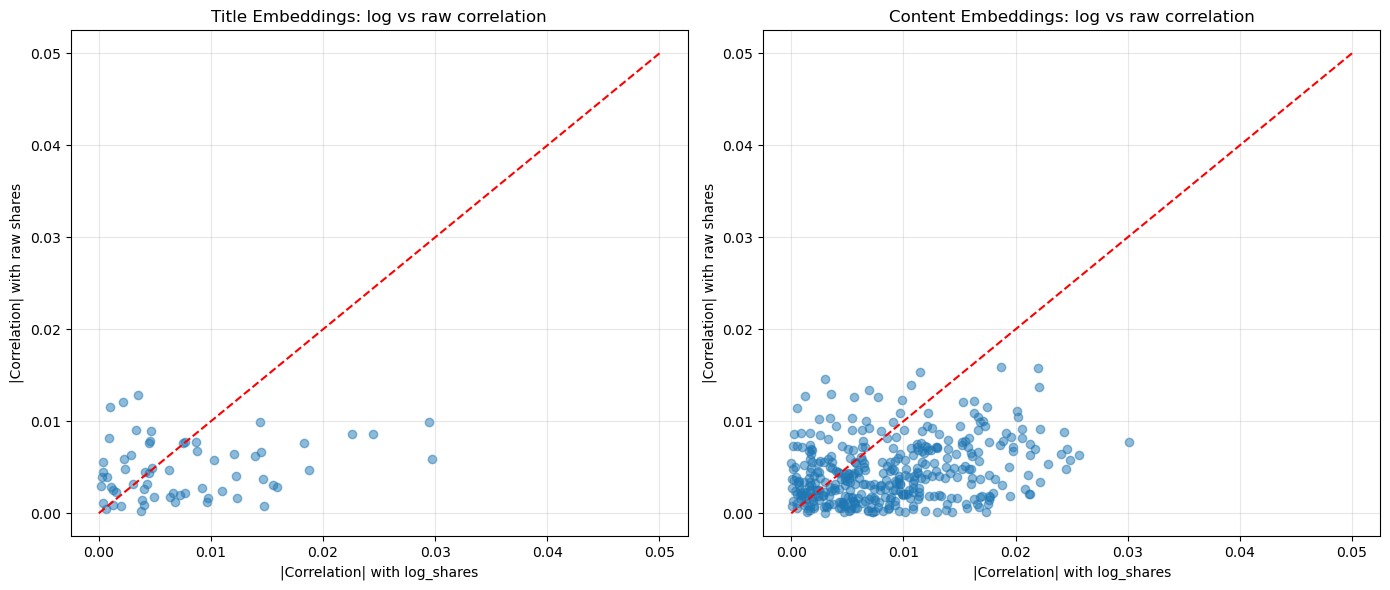

In [20]:
# Analyze correlation coefficients of embeddings with target variable
print("Analyzing correlation coefficients of embeddings with target variable")

# Create DataFrames with embeddings
title_emb_df = pd.DataFrame(title_embeddings_small, 
                           columns=[f'title_emb_{i}' for i in range(title_embeddings_small.shape[1])])
title_emb_df['log_shares'] = y_all  # Add target variable

content_emb_df = pd.DataFrame(content_embeddings, 
                             columns=[f'content_emb_{i}' for i in range(content_embeddings.shape[1])])
content_emb_df['log_shares'] = y_all  # Add target variable

# Calculate correlations with log_shares
title_emb_corrs = title_emb_df.corr()['log_shares'].drop('log_shares')
content_emb_corrs = content_emb_df.corr()['log_shares'].drop('log_shares')

# Calculate correlations with raw shares
title_emb_df['shares'] = art_share_pred['shares']
content_emb_df['shares'] = art_share_pred['shares']
title_shares_corrs = title_emb_df.corr()['shares'].drop(['log_shares', 'shares'])
content_shares_corrs = content_emb_df.corr()['shares'].drop(['log_shares', 'shares'])

# Analyze the distribution of correlation values (absolute)
print("\nTitle embeddings correlation statistics (with log_shares):")
print(title_emb_corrs.abs().describe())

print("\nContent embeddings correlation statistics (with log_shares):")
print(content_emb_corrs.abs().describe())

print("\nTitle embeddings correlation statistics (with raw shares):")
print(title_shares_corrs.abs().describe())

print("\nContent embeddings correlation statistics (with raw shares):")
print(content_shares_corrs.abs().describe())

# Count embeddings with correlation above threshold
correlation_threshold = 0.03  # Same as used for structured features
title_strong_log = (title_emb_corrs.abs() >= correlation_threshold).sum()
content_strong_log = (content_emb_corrs.abs() >= correlation_threshold).sum()
title_strong_raw = (title_shares_corrs.abs() >= correlation_threshold).sum()
content_strong_raw = (content_shares_corrs.abs() >= correlation_threshold).sum()

print(f"\nTitle embeddings with |correlation| >= {correlation_threshold} with log_shares: {title_strong_log} out of {title_emb_corrs.shape[0]} ({title_strong_log/title_emb_corrs.shape[0]:.1%})")
print(f"Content embeddings with |correlation| >= {correlation_threshold} with log_shares: {content_strong_log} out of {content_emb_corrs.shape[0]} ({content_strong_log/content_emb_corrs.shape[0]:.1%})")
print(f"Title embeddings with |correlation| >= {correlation_threshold} with raw shares: {title_strong_raw} out of {title_shares_corrs.shape[0]} ({title_strong_raw/title_shares_corrs.shape[0]:.1%})")
print(f"Content embeddings with |correlation| >= {correlation_threshold} with raw shares: {content_strong_raw} out of {content_shares_corrs.shape[0]} ({content_strong_raw/content_shares_corrs.shape[0]:.1%})")

# Show the top 10 most correlated embedding dimensions for each
print("\nTop 10 title embedding dimensions by correlation with log_shares:")
print(title_emb_corrs.abs().sort_values(ascending=False).head(10))

print("\nTop 10 content embedding dimensions by correlation with log_shares:")
print(content_emb_corrs.abs().sort_values(ascending=False).head(10))

print("\nTop 10 title embedding dimensions by correlation with raw shares:")
print(title_shares_corrs.abs().sort_values(ascending=False).head(10))

print("\nTop 10 content embedding dimensions by correlation with raw shares:")
print(content_shares_corrs.abs().sort_values(ascending=False).head(10))

# Visualize the distribution of correlation coefficients - LOG SHARES
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(title_emb_corrs.abs(), bins=30, alpha=0.7, color='blue', label='Title embeddings')
plt.axvline(x=correlation_threshold, color='red', linestyle='--', label=f'Threshold ({correlation_threshold})')
plt.title('Distribution of |Correlation| with log_shares\nTitle Embeddings')
plt.xlabel('Absolute Correlation')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(content_emb_corrs.abs(), bins=30, alpha=0.7, color='green', label='Content embeddings')
plt.axvline(x=correlation_threshold, color='red', linestyle='--', label=f'Threshold ({correlation_threshold})')
plt.title('Distribution of |Correlation| with log_shares\nContent Embeddings')
plt.xlabel('Absolute Correlation')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize the distribution of correlation coefficients - RAW SHARES
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(title_shares_corrs.abs(), bins=30, alpha=0.7, color='blue', label='Title embeddings')
plt.axvline(x=correlation_threshold, color='red', linestyle='--', label=f'Threshold ({correlation_threshold})')
plt.title('Distribution of |Correlation| with raw shares\nTitle Embeddings')
plt.xlabel('Absolute Correlation')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(content_shares_corrs.abs(), bins=30, alpha=0.7, color='green', label='Content embeddings')
plt.axvline(x=correlation_threshold, color='red', linestyle='--', label=f'Threshold ({correlation_threshold})')
plt.title('Distribution of |Correlation| with raw shares\nContent Embeddings')
plt.xlabel('Absolute Correlation')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Compare correlation distributions between structured features and embeddings - LOG SHARES
plt.figure(figsize=(10, 6))
structured_corrs = log_shares_corr.abs()

# Create boxplots
data = [structured_corrs, title_emb_corrs.abs(), content_emb_corrs.abs()]
labels = ['Structured Features', 'Title Embeddings', 'Content Embeddings']

plt.boxplot(data, labels=labels)
plt.axhline(y=correlation_threshold, color='red', linestyle='--', label=f'Threshold ({correlation_threshold})')
plt.title('Comparison of Correlation Distributions (with log_shares)')
plt.ylabel('Absolute Correlation with log_shares')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Compare correlation distributions between structured features and embeddings - RAW SHARES
plt.figure(figsize=(10, 6))
structured_corrs_raw = shares_corr.abs()

# Create boxplots for raw shares
data_raw = [structured_corrs_raw, title_shares_corrs.abs(), content_shares_corrs.abs()]
labels = ['Structured Features', 'Title Embeddings', 'Content Embeddings']

plt.boxplot(data_raw, labels=labels)
plt.axhline(y=correlation_threshold, color='red', linestyle='--', label=f'Threshold ({correlation_threshold})')
plt.title('Comparison of Correlation Distributions (with raw shares)')
plt.ylabel('Absolute Correlation with raw shares')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Side-by-side comparison of log vs raw correlations
plt.figure(figsize=(14, 6))

# Title embeddings comparison
plt.subplot(1, 2, 1)
plt.scatter(title_emb_corrs.abs(), title_shares_corrs.abs(), alpha=0.5)
plt.plot([0, 0.05], [0, 0.05], 'r--')  # Diagonal line for reference
plt.xlabel('|Correlation| with log_shares')
plt.ylabel('|Correlation| with raw shares')
plt.title('Title Embeddings: log vs raw correlation')
plt.grid(True, alpha=0.3)

# Content embeddings comparison
plt.subplot(1, 2, 2)
plt.scatter(content_emb_corrs.abs(), content_shares_corrs.abs(), alpha=0.5)
plt.plot([0, 0.05], [0, 0.05], 'r--')  # Diagonal line for reference
plt.xlabel('|Correlation| with log_shares')
plt.ylabel('|Correlation| with raw shares')
plt.title('Content Embeddings: log vs raw correlation')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Findings indicate that, as a whole, the emeddings have very weak correlation to the target feature of shares, both in the transformed and raw state

In [21]:
# Feature selection based on correlation with target variable (NO EMBEDDINGS)
print("Feature selection based on correlation with target variable (both log and raw shares) - NO EMBEDDINGS")

# Set correlation threshold
correlation_threshold = 0.03  # Absolute correlation value below which features are considered weak

# Get correlations with log_shares and raw shares (already calculated in previous cells)
log_shares_corr_abs = log_shares_corr.abs()
shares_corr_abs = shares_corr.abs()

# Identify features with correlation above threshold for either log_shares or raw shares
strong_features_log = log_shares_corr_abs[log_shares_corr_abs >= correlation_threshold].index.tolist()
strong_features_raw = shares_corr_abs[shares_corr_abs >= correlation_threshold].index.tolist()

# Combine the strong features from both sets (union)
strong_features = list(set(strong_features_log + strong_features_raw))
weak_features = [f for f in structured_features if f not in strong_features]

print(f"\nFeatures with correlation >= {correlation_threshold} with log_shares: {len(strong_features_log)}")
print(f"Features with correlation >= {correlation_threshold} with raw shares: {len(strong_features_raw)}")
print(f"Combined unique strong features: {len(strong_features)}")
print(f"Features with correlation < {correlation_threshold} with both: {len(weak_features)}")

print("\nTop 10 strongest correlations with log_shares:")
print(log_shares_corr.abs().sort_values(ascending=False).head(10))

print("\nTop 10 strongest correlations with raw shares:")
print(shares_corr.abs().sort_values(ascending=False).head(10))

# Create indices for strong features
strong_structured_indices = [i for i, feature in enumerate(structured_features) if feature in strong_features]

# Create reduced feature matrix - STRUCTURED FEATURES ONLY (no embeddings)
X_structured_reduced = X_structured_scaled[:, strong_structured_indices]
print(f"\nReduced structured feature matrix shape: {X_structured_reduced.shape} (was {X_structured_scaled.shape})")

# NO EMBEDDINGS: Use only structured features
X_all_reduced_no_embeddings = X_structured_reduced
print(f"Final reduced feature matrix shape: {X_all_reduced_no_embeddings.shape} (was {X_all.shape}) - EMBEDDINGS DROPPED")
print(f"Total feature reduction: {X_all.shape[1] - X_all_reduced_no_embeddings.shape[1]} features removed ({(1 - X_all_reduced_no_embeddings.shape[1]/X_all.shape[1])*100:.1f}% reduction)")

# Split into train and test sets
X_train_reduced_no_embeddings, X_test_reduced_no_embeddings, y_train_reduced_no_embeddings, y_test_reduced_no_embeddings = train_test_split(
    X_all_reduced_no_embeddings, y_all, test_size=0.2, random_state=33
)

print(f"Reduced training set shape (no embeddings): {X_train_reduced_no_embeddings.shape} (was {X_train.shape})") 
print(f"Reduced test set shape (no embeddings): {X_test_reduced_no_embeddings.shape} (was {X_test.shape})")
print(f"Note: y_train_reduced_no_embeddings and y_test_reduced_no_embeddings contain the same target values as the original split")

# Use X_train_reduced_no_embeddings and X_test_reduced_no_embeddings for GridSearchCV
print("\nYou can now run GridSearchCV with these reduced features (structured only) for MUCH faster training")


Feature selection based on correlation with target variable (both log and raw shares) - NO EMBEDDINGS

Features with correlation >= 0.03 with log_shares: 41
Features with correlation >= 0.03 with raw shares: 17
Combined unique strong features: 41
Features with correlation < 0.03 with both: 19

Top 10 strongest correlations with log_shares:
kw_avg_avg               0.221822
LDA_02                   0.165076
data_channel_is_world    0.151685
LDA_03                   0.126037
channel                  0.118830
is_weekend               0.114391
kw_max_avg               0.109343
kw_min_avg               0.108850
num_hrefs                0.105142
num_imgs                 0.091519
Name: log_shares, dtype: float64

Top 10 strongest correlations with raw shares:
kw_avg_avg                    0.110413
LDA_03                        0.083771
channel                       0.071568
kw_max_avg                    0.064306
LDA_02                        0.059163
self_reference_avg_sharess    0.057789
sel

In [22]:
# Evaluate baseline Gradient Boosting Regressor with structured features only (NO EMBEDDINGS)
print("Evaluating baseline Gradient Boosting Regressor with structured features only (NO EMBEDDINGS)")

# Create and train a standard GBR with default hyperparameters
gbr_baseline = GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=33)
print("Training GBR with structured features only...")
gbr_baseline.fit(X_train_reduced_no_embeddings, y_train_reduced_no_embeddings)

# Evaluate on test set
y_pred = gbr_baseline.predict(X_test_reduced_no_embeddings)
rmse = np.sqrt(mean_squared_error(y_test_reduced_no_embeddings, y_pred))
mae = mean_absolute_error(y_test_reduced_no_embeddings, y_pred)
r2 = r2_score(y_test_reduced_no_embeddings, y_pred)
mape_log = mean_absolute_percentage_error(y_test_reduced_no_embeddings, y_pred)
predicted_shares = np.expm1(y_pred)
actual_shares_for_eval = np.expm1(y_test_reduced_no_embeddings)
mape_actual = mean_absolute_percentage_error(actual_shares_for_eval, predicted_shares)

print(f'Baseline GBR metrics (NO EMBEDDINGS):')
print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'mape (log-shares): {mape_log:.4f}')
print(f'mape (actual shares): {mape_actual:.4f}')
print(f'r2: {r2:.4f}')

# Remove any previous "NO EMBEDDINGS" results to avoid duplicates
model_results = [result for result in model_results if "NO EMBEDDINGS" not in result['model']]

# Add the new result to model_results
model_results.append({
    'model': 'gradient boosting (structured features only, NO EMBEDDINGS)',
    'rmse': rmse,
    'mae': mae,
    'mape_log': mape_log,
    'mape_actual': mape_actual,
    'r2': r2
})

# Compare with previous GBR model that used all features
print("\nComparing with previous GBR model (with embeddings):")
prev_gbr_results = next((item for item in model_results if item['model'] == 'gradient boosting regressor'), None)
if prev_gbr_results:
    print(f"Previous GBR (with embeddings) RMSE: {prev_gbr_results['rmse']:.4f}")
    print(f"Previous GBR (with embeddings) MAE: {prev_gbr_results['mae']:.4f}")
    print(f"Previous GBR (with embeddings) MAPE (log): {prev_gbr_results['mape_log']:.4f}")
    print(f"Previous GBR (with embeddings) MAPE (actual): {prev_gbr_results['mape_actual']:.4f}")
    print(f"Previous GBR (with embeddings) R²: {prev_gbr_results['r2']:.4f}")
    
    # Calculate differences
    rmse_diff = rmse - prev_gbr_results['rmse']
    mae_diff = mae - prev_gbr_results['mae']
    mape_log_diff = mape_log - prev_gbr_results['mape_log']
    mape_actual_diff = mape_actual - prev_gbr_results['mape_actual']
    r2_diff = r2 - prev_gbr_results['r2']
    
    print(f"\nDifferences (NO EMBEDDINGS - WITH EMBEDDINGS):")
    print(f"RMSE difference: {rmse_diff:.4f} ({'worse' if rmse_diff > 0 else 'better'})")
    print(f"MAE difference: {mae_diff:.4f} ({'worse' if mae_diff > 0 else 'better'})")
    print(f"MAPE (log) difference: {mape_log_diff:.4f} ({'worse' if mape_log_diff > 0 else 'better'})")
    print(f"MAPE (actual) difference: {mape_actual_diff:.4f} ({'worse' if mape_actual_diff > 0 else 'better'})")
    print(f"R² difference: {r2_diff:.4f} ({'better' if r2_diff > 0 else 'worse'})")

# Update results DataFrame
results_df = pd.DataFrame(model_results)
results_df = results_df[['model', 'rmse', 'mae', 'mape_log', 'mape_actual', 'r2']]
results_df = results_df.sort_values(by='mape_actual')

# Create a comparison DataFrame specifically for GBR models with and without embeddings
gbr_comparison = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'MAPE (log)', 'MAPE (actual)', 'R²'],
    'with_embeddings': [prev_gbr_results['rmse'], prev_gbr_results['mae'], 
                        prev_gbr_results['mape_log'], prev_gbr_results['mape_actual'], 
                        prev_gbr_results['r2']],
    'no_embeddings': [rmse, mae, mape_log, mape_actual, r2],
    'difference': [rmse_diff, mae_diff, mape_log_diff, mape_actual_diff, r2_diff],
    'better_model': ['With Embeddings' if rmse_diff > 0 else 'No Embeddings',
                    'No Embeddings' if mae_diff < 0 else 'With Embeddings',
                    'No Embeddings' if mape_log_diff < 0 else 'With Embeddings',
                    'With Embeddings' if mape_actual_diff > 0 else 'No Embeddings',
                    'With Embeddings' if r2_diff < 0 else 'No Embeddings']
})

# Save results to CSV
results_df.to_csv('gbr_results_summary.csv', index=False)
gbr_comparison.to_csv('gbr_comparison.csv', index=False)

print("\nResults saved to 'gbr_results_summary.csv' and detailed GBR comparison saved to 'gbr_comparison.csv'")

# Display updated results
results_df


Evaluating baseline Gradient Boosting Regressor with structured features only (NO EMBEDDINGS)
Training GBR with structured features only...
Baseline GBR metrics (NO EMBEDDINGS):
rmse: 0.8500
mae: 0.6262
mape (log-shares): 0.0832
mape (actual shares): 0.7931
r2: 0.1572

Comparing with previous GBR model (with embeddings):
Previous GBR (with embeddings) RMSE: 0.8477
Previous GBR (with embeddings) MAE: 0.6271
Previous GBR (with embeddings) MAPE (log): 0.0832
Previous GBR (with embeddings) MAPE (actual): 0.7920
Previous GBR (with embeddings) R²: 0.1617

Differences (NO EMBEDDINGS - WITH EMBEDDINGS):
RMSE difference: 0.0023 (worse)
MAE difference: -0.0009 (better)
MAPE (log) difference: -0.0000 (better)
MAPE (actual) difference: 0.0010 (worse)
R² difference: -0.0045 (worse)

Results saved to 'gbr_results_summary.csv' and detailed GBR comparison saved to 'gbr_comparison.csv'


,model,rmse,mae,mape_log,mape_actual,r2
4,gradient boosting regressor,0.847719,0.627077,0.083228,0.792046,0.161671
6,"gradient boosting (structured features only, N...",0.849979,0.626199,0.083208,0.793093,0.157193
0,linear regression,0.867338,0.642023,0.085227,0.809975,0.122417
1,ridge regression,0.866596,0.641822,0.085241,0.814175,0.123918
3,random forest regressor,0.868534,0.646870,0.086048,0.826576,0.119996
2,lasso regression,0.925897,0.703341,0.093642,0.882649,-0.000084
5,xgboost regressor,0.903115,0.671789,0.089131,0.891315,0.048525


Results indicate that model without embeddings and reduced feature set performed nearly identically to model with embeddings and full feature set. For comutational efficiency, we will proceed with the no embeddings, reduced feature set gb model

In [50]:
# (OPTIONAL) Hyperparameter tuning for Gradient Boosting Regressor with NO EMBEDDINGS
from sklearn.model_selection import GridSearchCV

print("(OPTIONAL) Hyperparameter tuning for Gradient Boosting Regressor using structured features only (NO EMBEDDINGS)")
print("NOTE: You can run this cell after evaluating the baseline results if you want to optimize further")

# Define parameter grid
param_grid = {
    'n_estimators': [50, 75],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 1.0]
}

# Create base model
gbr_no_embeddings = GradientBoostingRegressor(random_state=33)

# Create GridSearchCV object with 5-fold cross-validation
grid_search_no_embeddings = GridSearchCV(
    estimator=gbr_no_embeddings,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search using no-embeddings feature set
print("Starting grid search with structured features only (NO EMBEDDINGS)...")
print(f"Using {X_train_reduced_no_embeddings.shape[1]} features instead of {X_train.shape[1]} (reduced by {X_train.shape[1] - X_train_reduced_no_embeddings.shape[1]} features)")

grid_search_no_embeddings.fit(X_train_reduced_no_embeddings, y_train_reduced_no_embeddings)

# Print best parameters and score
print(f"Best parameters: {grid_search_no_embeddings.best_params_}")
print(f"Best negative MAPE: {grid_search_no_embeddings.best_score_:.4f}")

# Get the best model
best_gbr_no_embeddings = grid_search_no_embeddings.best_estimator_

# Evaluate on test set
y_pred = best_gbr_no_embeddings.predict(X_test_reduced_no_embeddings)
rmse = np.sqrt(mean_squared_error(y_test_reduced_no_embeddings, y_pred))
mae = mean_absolute_error(y_test_reduced_no_embeddings, y_pred)
r2 = r2_score(y_test_reduced_no_embeddings, y_pred)
mape_log = mean_absolute_percentage_error(y_test_reduced_no_embeddings, y_pred)
predicted_shares = np.expm1(y_pred)
actual_shares_for_eval = np.expm1(y_test_reduced_no_embeddings)
mape_actual = mean_absolute_percentage_error(actual_shares_for_eval, predicted_shares)

print(f'Tuned model metrics (NO EMBEDDINGS):')
print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'mape (log-shares): {mape_log:.4f}')
print(f'mape (actual shares): {mape_actual:.4f}')
print(f'r2: {r2:.4f}')

# Compare with baseline GBR (no embeddings)
baseline_no_emb_results = next((item for item in model_results if item['model'] == 'gradient boosting (structured features only, NO EMBEDDINGS)'), None)
if baseline_no_emb_results:
    print("\nComparing with baseline GBR (no embeddings):")
    print(f"Improvement in RMSE: {baseline_no_emb_results['rmse'] - rmse:.4f}")
    print(f"Improvement in MAE: {baseline_no_emb_results['mae'] - mae:.4f}")
    print(f"Improvement in MAPE (log): {baseline_no_emb_results['mape_log'] - mape_log:.4f}")
    print(f"Improvement in MAPE (actual): {baseline_no_emb_results['mape_actual'] - mape_actual:.4f}")
    print(f"Improvement in R²: {r2 - baseline_no_emb_results['r2']:.4f}")

# Add to model results
model_results.append({
    'model': 'tuned gradient boosting (structured features only, NO EMBEDDINGS)',
    'rmse': rmse,
    'mae': mae,
    'mape_log': mape_log,
    'mape_actual': mape_actual,
    'r2': r2
})

# Update results DataFrame
results_df = pd.DataFrame(model_results)
results_df = results_df[['model', 'rmse', 'mae', 'mape_log', 'mape_actual', 'r2']]
results_df = results_df.sort_values(by='mape_actual')

# Save updated results
results_df.to_pickle('/Users/croy/Documents/m2/asp_model_results_summary.pkl')
results_df.to_parquet('/Users/croy/Documents/m2/asp_model_results_summary.parquet')
results_df.to_csv('/Users/croy/Documents/m2/asp_model_results_summary.csv', index=False)

# Display updated results
results_df


(OPTIONAL) Hyperparameter tuning for Gradient Boosting Regressor using structured features only (NO EMBEDDINGS)
NOTE: You can run this cell after evaluating the baseline results if you want to optimize further
Starting grid search with structured features only (NO EMBEDDINGS)...
Using 40 features instead of 507 (reduced by 467 features)
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 75, 'subsample': 0.8}
Best negative MAPE: -0.0836
Tuned model metrics (NO EMBEDDINGS):
rmse: 0.8518
mae: 0.6262
mape (log-shares): 0.0833
mape (actual shares): 0.8280
r2: 0.1535

Comparing with baseline GBR (no embeddings):
Improvement in RMSE: -0.0018
Improvement in MAE: -0.0000
Improvement in MAPE (log): -0.0001
Improvement in MAPE (actual): -0.0349
Improvement in R²: -0.0037


,model,rmse,mae,mape_log,mape_actual,r2
4,gradient boosting regressor,0.847719,0.627077,0.083228,0.792046,0.161671
6,"gradient boosting (structured features only, N...",0.849979,0.626199,0.083208,0.793093,0.157193
0,linear regression,0.867338,0.642023,0.085227,0.809975,0.122417
1,ridge regression,0.866596,0.641822,0.085241,0.814175,0.123918
3,random forest regressor,0.868534,0.646870,0.086048,0.826576,0.119996
7,tuned gradient boosting (structured features o...,0.851820,0.626245,0.083265,0.828008,0.153538
2,lasso regression,0.925897,0.703341,0.093642,0.882649,-0.000084
5,xgboost regressor,0.903115,0.671789,0.089131,0.891315,0.048525


Results would indicate that attempted tuning did not yield increased model performance

In [23]:
# Cross-validation evaluation for all models
from sklearn.model_selection import cross_val_score

print("Cross-validation results for all model families")

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=33),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=33),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=33),
    'XGBoost': XGBRegressor(n_estimators=150, max_depth=10, random_state=33)
}

# Add the best model from hyperparameter tuning if available
if 'best_gbr_no_embeddings' in locals():
    models['Tuned Gradient Boosting'] = best_gbr_no_embeddings

# Metrics to evaluate
metrics = {
    'neg_root_mean_squared_error': 'RMSE',
    'neg_mean_absolute_error': 'MAE',
    'r2': 'R²'
}

# Store results
cv_results = []

# Use reduced_no_embedding feature set for cross-validation
X_for_cv = X_all_reduced_no_embeddings
print(f"Using reduced_no_embedding feature set for cross-validation (shape: {X_for_cv.shape})")

# Perform 5-fold cross-validation for each model and metric
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    model_results = {'Model': model_name}
    
    for metric_name, metric_label in metrics.items():
        scores = cross_val_score(model, X_for_cv, y_all, cv=5, scoring=metric_name, n_jobs=-1)
        
        # For negative metrics, convert to positive
        if metric_name.startswith('neg_'):
            scores = -scores
            
        mean_score = scores.mean()
        std_score = scores.std()
        
        print(f"{metric_label}: {mean_score:.4f} ± {std_score:.4f}")
        model_results[f'{metric_label} Mean'] = mean_score
        model_results[f'{metric_label} Std'] = std_score
    
    cv_results.append(model_results)

# Create DataFrame with results
cv_results_df = pd.DataFrame(cv_results)

# Display results
cv_results_df


Cross-validation results for all model families
Using reduced_no_embedding feature set for cross-validation (shape: (39644, 40))

Evaluating Linear Regression...
RMSE: 10856504.4199 ± 21713007.0486
MAE: 121922.2841 ± 243843.2369
R²: -770615282182236.6250 ± 1541230564364473.2500

Evaluating Ridge Regression...
RMSE: 0.8778 ± 0.0479
MAE: 0.6498 ± 0.0493
R²: 0.0987 ± 0.0417

Evaluating Random Forest...
RMSE: 0.8806 ± 0.0463
MAE: 0.6564 ± 0.0443
R²: 0.0920 ± 0.0546

Evaluating Gradient Boosting...
RMSE: 0.8749 ± 0.0515
MAE: 0.6460 ± 0.0471
R²: 0.1021 ± 0.0874

Evaluating XGBoost...
RMSE: 0.9426 ± 0.0536
MAE: 0.7040 ± 0.0478
R²: -0.0425 ± 0.1028


,Model,RMSE Mean,RMSE Std,MAE Mean,MAE Std,R² Mean,R² Std
0,Linear Regression,1.085650e+07,2.171301e+07,121922.284127,243843.236896,-7.706153e+14,1.541231e+15
1,Ridge Regression,8.777787e-01,4.794342e-02,0.649824,0.049342,9.866672e-02,4.167453e-02
2,Random Forest,8.806161e-01,4.630081e-02,0.656422,0.044290,9.202803e-02,5.456406e-02
3,Gradient Boosting,8.748570e-01,5.150627e-02,0.645955,0.047073,1.021485e-01,8.744148e-02
4,XGBoost,9.425604e-01,5.357683e-02,0.704035,0.047818,-4.254329e-02,1.027576e-01


Feature importance analysis for Gradient Boosting model
Using reduced_no_embedding feature set for training

Top 20 most important features for Gradient Boosting (No Embeddings):
                          Feature  Importance
16                     kw_avg_avg    0.274977
19     self_reference_avg_sharess    0.081316
17      self_reference_min_shares    0.063414
0                       num_hrefs    0.051022
15                     kw_max_avg    0.047484
24                     is_weekend    0.046300
13                     kw_avg_max    0.035273
14                     kw_min_avg    0.033339
12                     kw_avg_min    0.029235
3            average_token_length    0.026619
6   data_channel_is_entertainment    0.026559
25                         LDA_00    0.024836
27                         LDA_02    0.024374
9            data_channel_is_tech    0.023403
1                        num_imgs    0.021635
26                         LDA_01    0.017488
8          data_channel_is_socmed    0.

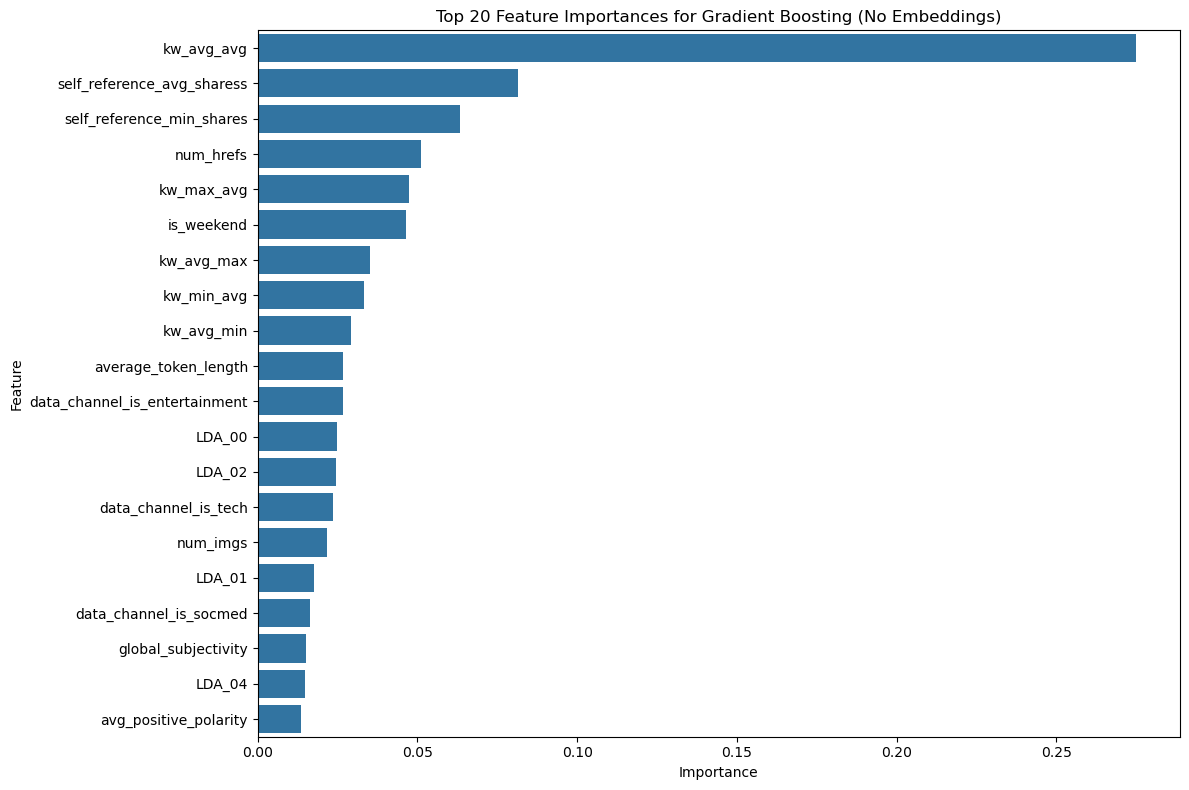

In [24]:
# Feature importance analysis
print("Feature importance analysis for Gradient Boosting model")

# Get the best model (either tuned or original)
if 'best_gbr_no_embeddings' in locals():
    best_model = best_gbr_no_embeddings
    model_name = "Tuned Gradient Boosting (No Embeddings)"
else:
    best_model = GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=33)
    # Use reduced_no_embedding features
    best_model.fit(X_train_reduced_no_embeddings, y_train_reduced_no_embeddings)
    print("Using reduced_no_embedding feature set for training")
    model_name = "Gradient Boosting (No Embeddings)"

# Get feature importances
importances = best_model.feature_importances_

# Create a DataFrame for feature importances
# For reduced_no_embedding features, we need the correct feature names
strong_feature_names = [structured_features[i] for i in strong_structured_indices]
feature_names = strong_feature_names

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Display top 20 most important features
print(f"\nTop 20 most important features for {model_name}:")
top_20_features = importance_df.head(20)
print(top_20_features)

# Visualize top features
plt.figure(figsize=(12, 8))
sns.barplot(data=top_20_features, x='Importance', y='Feature')
plt.title(f'Top 20 Feature Importances for {model_name}')
plt.tight_layout()
plt.show()

# Note: Since we're using only structured features (no embeddings),
# we don't need to show importance by feature type


Ablation study: Testing model performance with different feature subsets
Using reduced_no_embedding feature set for ablation study

Evaluating All Features...
rmse: 0.8500
mae: 0.6262
mape (log-shares): 0.0832
mape (actual shares): 0.7931
r2: 0.1572

Evaluating Top 5 Features...
rmse: 0.8720
mae: 0.6527
mape (log-shares): 0.0869
mape (actual shares): 0.8310
r2: 0.1129

Evaluating Top 10 Features...
rmse: 0.8612
mae: 0.6391
mape (log-shares): 0.0850
mape (actual shares): 0.8325
r2: 0.1349

Evaluating Top 20 Features...
rmse: 0.8504
mae: 0.6266
mape (log-shares): 0.0833
mape (actual shares): 0.7984
r2: 0.1564

Evaluating Bottom Half Features...
rmse: 0.8857
mae: 0.6643
mape (log-shares): 0.0883
mape (actual shares): 0.8359
r2: 0.0849

Evaluating All Except Top 5...
rmse: 0.8618
mae: 0.6372
mape (log-shares): 0.0847
mape (actual shares): 0.8157
r2: 0.1335

Evaluating All Except Bottom Half...
rmse: 0.8503
mae: 0.6266
mape (log-shares): 0.0833
mape (actual shares): 0.7984
r2: 0.1565

Ablat

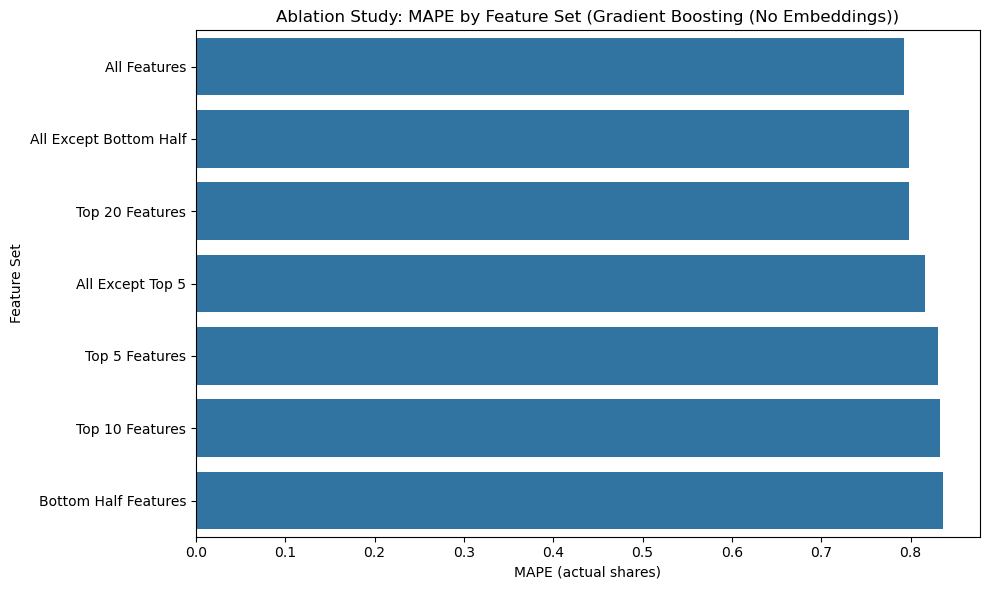

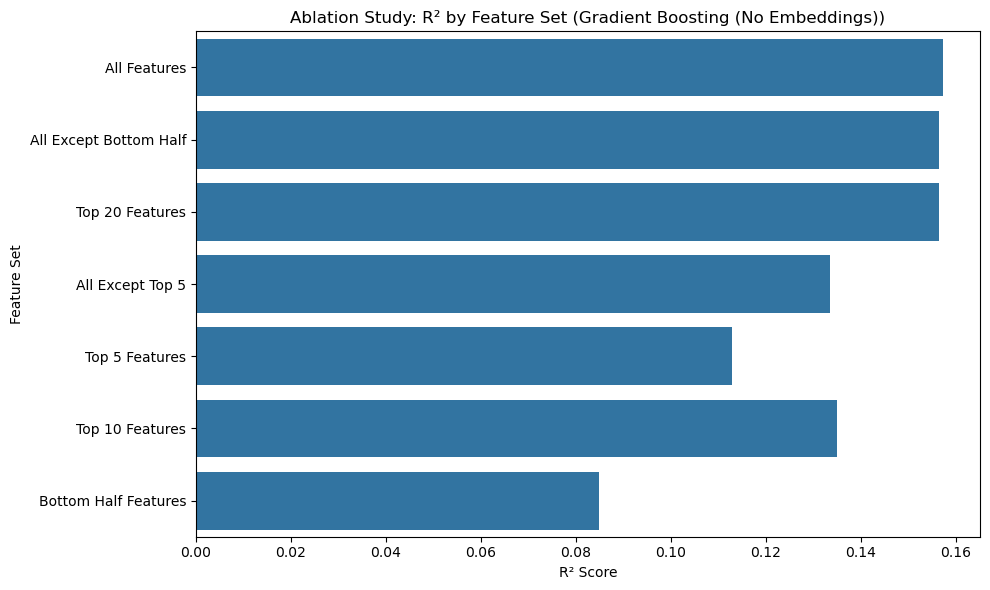

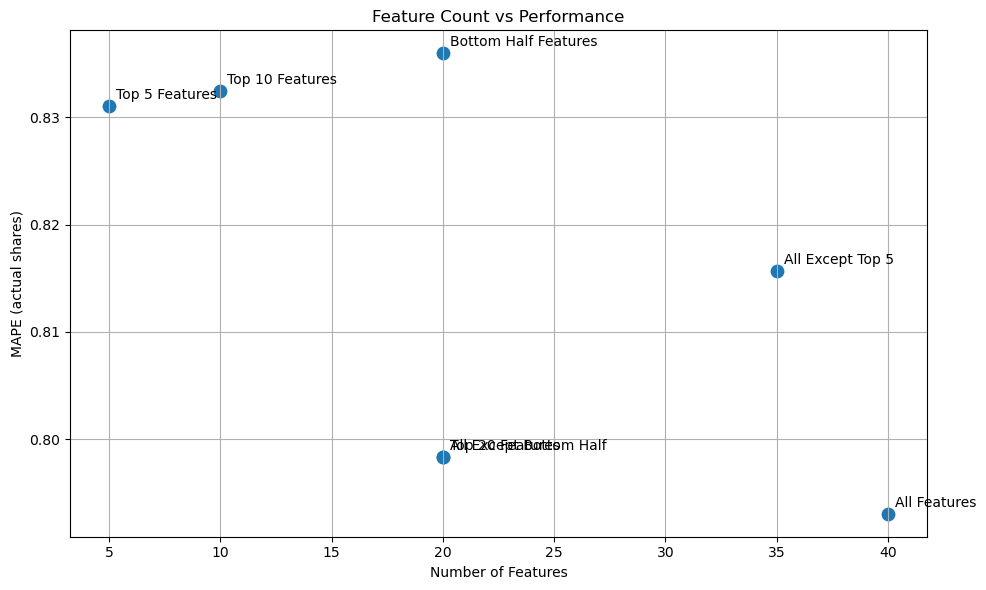

In [25]:
# Ablation study - testing model performance with different feature subsets
print("Ablation study: Testing model performance with different feature subsets")

print("Using reduced_no_embedding feature set for ablation study")

# For reduced_no_embedding features, we only have structured features
# So our ablation study will focus on feature importance groups
from sklearn.base import clone

# Get top feature importances from the model
if 'best_gbr_no_embeddings' in locals():
    model = best_gbr_no_embeddings
    model_name = "Tuned Gradient Boosting (No Embeddings)"
else:
    model = GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=33)
    model.fit(X_train_reduced_no_embeddings, y_train_reduced_no_embeddings)
    model_name = "Gradient Boosting (No Embeddings)"

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for feature importances
strong_feature_names = [structured_features[i] for i in strong_structured_indices]
importance_df = pd.DataFrame({
    'Feature': strong_feature_names,
    'Importance': importances,
    'Index': range(len(strong_feature_names))
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Create feature groups based on importance
top_5_indices = importance_df.head(5)['Index'].tolist()
top_10_indices = importance_df.head(10)['Index'].tolist()
top_20_indices = importance_df.head(20)['Index'].tolist()
bottom_half_indices = importance_df.tail(len(importance_df)//2)['Index'].tolist()

# Define feature subsets for ablation
feature_subsets = {
    'All Features': list(range(X_all_reduced_no_embeddings.shape[1])),
    'Top 5 Features': top_5_indices,
    'Top 10 Features': top_10_indices,
    'Top 20 Features': top_20_indices,
    'Bottom Half Features': bottom_half_indices,
    'All Except Top 5': [i for i in range(X_all_reduced_no_embeddings.shape[1]) if i not in top_5_indices],
    'All Except Bottom Half': [i for i in range(X_all_reduced_no_embeddings.shape[1]) if i not in bottom_half_indices]
}

# Use the reduced_no_embedding datasets for evaluation
X_train_for_ablation = X_train_reduced_no_embeddings
X_test_for_ablation = X_test_reduced_no_embeddings
y_train_for_ablation = y_train_reduced_no_embeddings
y_test_for_ablation = y_test_reduced_no_embeddings
actual_shares_for_ablation = np.expm1(y_test_reduced_no_embeddings)

# Results storage
ablation_results = []

# Evaluate each feature subset
for subset_name, indices in feature_subsets.items():
    print(f"\nEvaluating {subset_name}...")
    
    # Extract subset of features
    X_train_subset = X_train_for_ablation[:, indices]
    X_test_subset = X_test_for_ablation[:, indices]
    
    # Train model
    model_copy = clone(model)
    model_copy.fit(X_train_subset, y_train_for_ablation)
    
    # Evaluate
    y_pred = model_copy.predict(X_test_subset)
    rmse = np.sqrt(mean_squared_error(y_test_for_ablation, y_pred))
    mae = mean_absolute_error(y_test_for_ablation, y_pred)
    r2 = r2_score(y_test_for_ablation, y_pred)
    mape_log = mean_absolute_percentage_error(y_test_for_ablation, y_pred)
    predicted_shares = np.expm1(y_pred)
    mape_actual = mean_absolute_percentage_error(actual_shares_for_ablation, predicted_shares)
    
    print(f'rmse: {rmse:.4f}')
    print(f'mae: {mae:.4f}')
    print(f'mape (log-shares): {mape_log:.4f}')
    print(f'mape (actual shares): {mape_actual:.4f}')
    print(f'r2: {r2:.4f}')
    
    # Store results
    ablation_results.append({
        'Feature Set': subset_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (log)': mape_log,
        'MAPE (actual)': mape_actual,
        'R²': r2,
        'Feature Count': len(indices)
    })

# Create DataFrame
ablation_df = pd.DataFrame(ablation_results)

# Sort by performance
ablation_df = ablation_df.sort_values('MAPE (actual)')

# Display results
print("\nAblation study results (sorted by MAPE):")
ablation_df

# Visualize results
plt.figure(figsize=(10, 6))
sns.barplot(data=ablation_df, x='MAPE (actual)', y='Feature Set')
plt.title(f'Ablation Study: MAPE by Feature Set ({model_name})')
plt.xlabel('MAPE (actual shares)')
plt.tight_layout()
plt.show()

# Visualize R² scores
plt.figure(figsize=(10, 6))
sns.barplot(data=ablation_df, x='R²', y='Feature Set')
plt.title(f'Ablation Study: R² by Feature Set ({model_name})')
plt.xlabel('R² Score')
plt.tight_layout()
plt.show()

# Visualize feature count vs performance
plt.figure(figsize=(10, 6))
plt.scatter(ablation_df['Feature Count'], ablation_df['MAPE (actual)'], s=80)
for i, txt in enumerate(ablation_df['Feature Set']):
    plt.annotate(txt, (ablation_df['Feature Count'].iloc[i], ablation_df['MAPE (actual)'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.title('Feature Count vs Performance')
plt.xlabel('Number of Features')
plt.ylabel('MAPE (actual shares)')
plt.grid(True)
plt.tight_layout()
plt.show()


Sensitivity analysis: Impact of hyperparameters on model performance
Using reduced_no_embedding feature set for sensitivity analysis

Analyzing sensitivity to n_estimators...


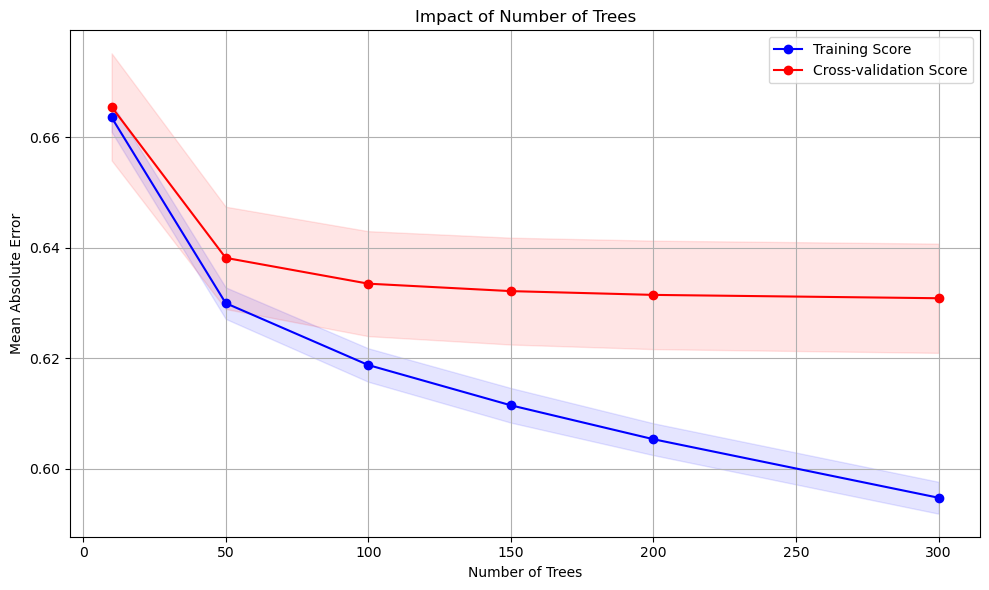

Optimal n_estimators = 300 (MAE = 0.6309)

Analyzing sensitivity to max_depth...


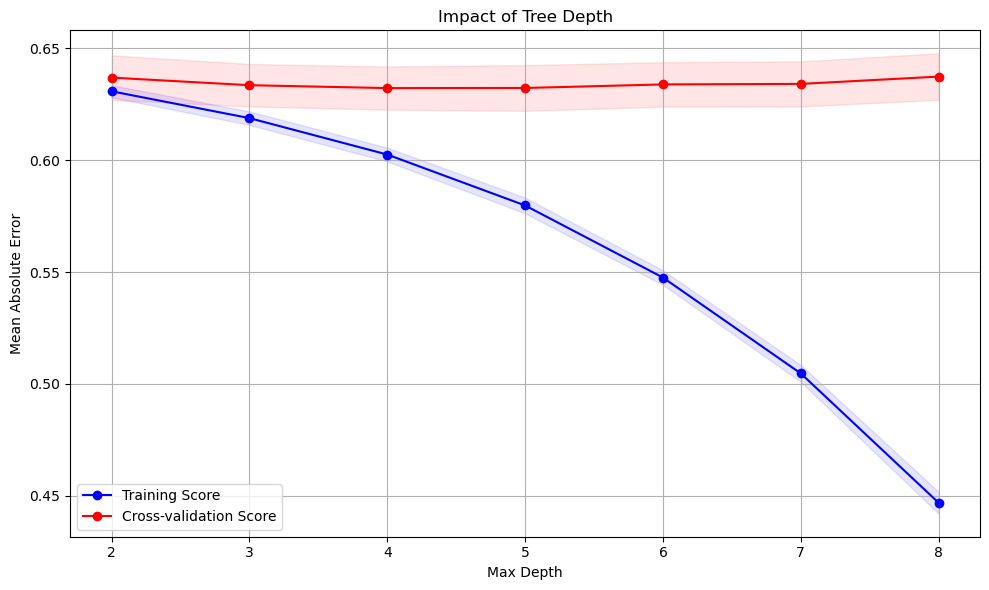

Optimal max_depth = 4 (MAE = 0.6322)

Analyzing sensitivity to learning_rate...


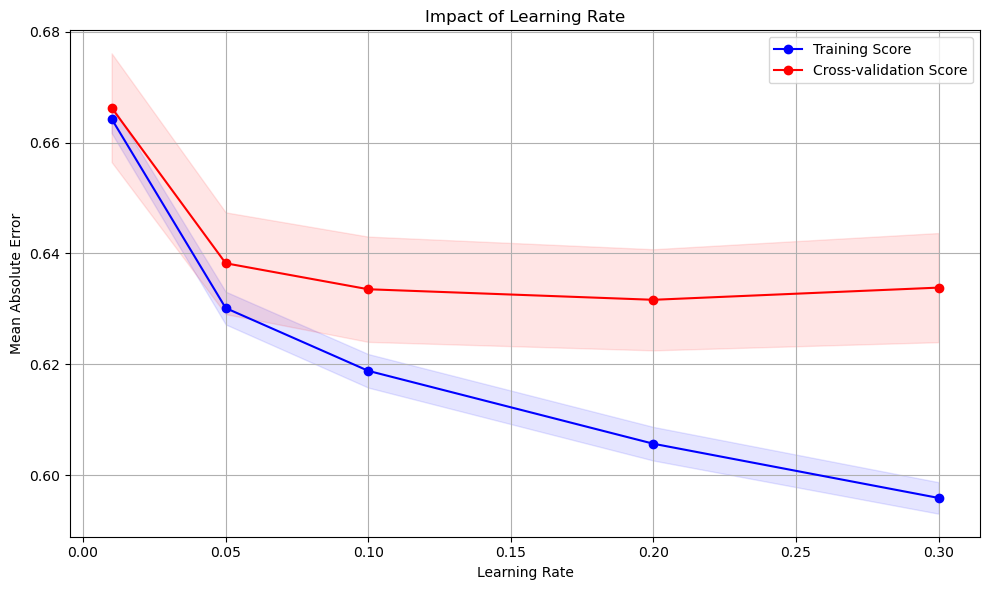

Optimal learning_rate = 0.2 (MAE = 0.6316)

Analyzing sensitivity to training data size...
Training with 10% of training data...
Training with 20% of training data...
Training with 40% of training data...
Training with 60% of training data...
Training with 80% of training data...
Training with 100% of training data...

Impact of training data size:
  Training Size  Samples      RMSE       MAE        R²
0           10%     3171  0.889135  0.662906  0.077755
1           20%     6343  0.873676  0.647191  0.109546
2           40%    12686  0.859519  0.635559  0.138169
3           60%    19029  0.856399  0.631658  0.144414
4           80%    25372  0.851825  0.626733  0.153529
5          100%    31715  0.849537  0.624556  0.158070


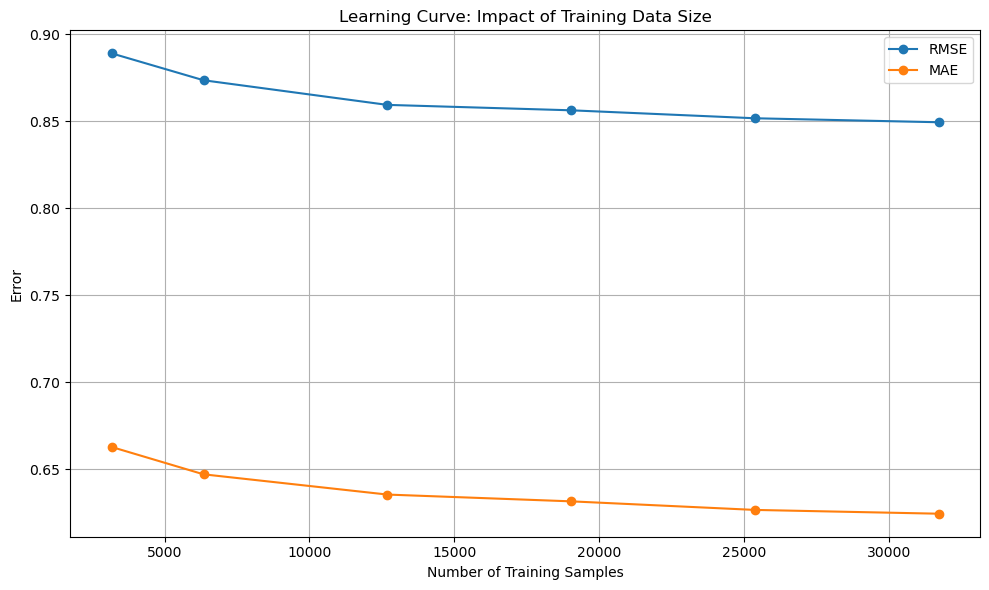

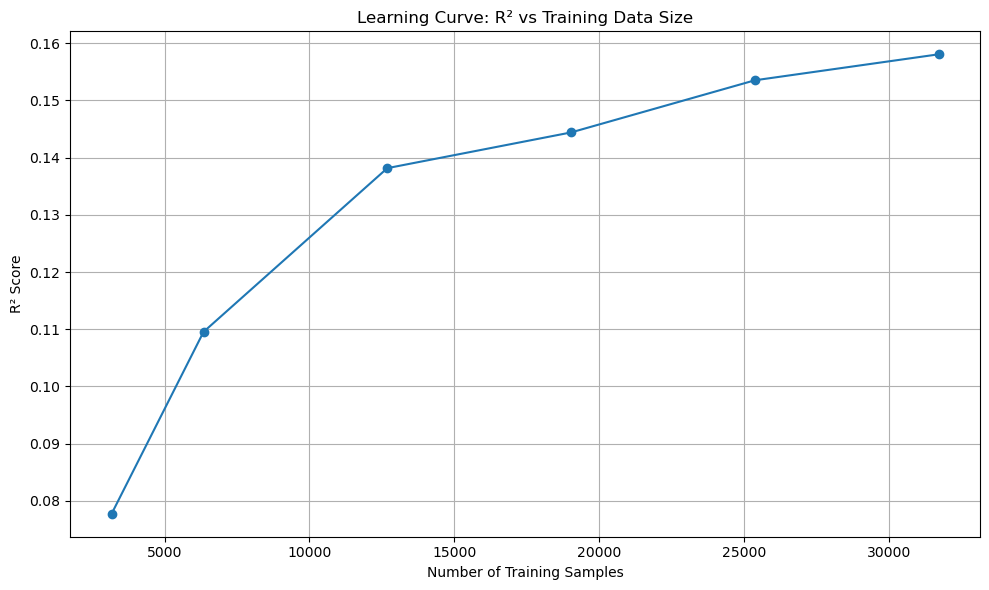

In [26]:
# Sensitivity analysis - how model performance changes with hyperparameters
print("Sensitivity analysis: Impact of hyperparameters on model performance")

# Import necessary libraries
from sklearn.model_selection import validation_curve
from sklearn.base import clone

# Define the model
base_model = GradientBoostingRegressor(random_state=33)

print("Using reduced_no_embedding feature set for sensitivity analysis")

# Set X and y for analysis
X_for_sensitivity = X_train_reduced_no_embeddings
y_for_sensitivity = y_train_reduced_no_embeddings

# Parameters to analyze
param_analyses = [
    {
        'param_name': 'n_estimators',
        'param_range': [10, 50, 100, 150, 200, 300],
        'title': 'Impact of Number of Trees',
        'xlabel': 'Number of Trees'
    },
    {
        'param_name': 'max_depth',
        'param_range': [2, 3, 4, 5, 6, 7, 8],
        'title': 'Impact of Tree Depth',
        'xlabel': 'Max Depth'
    },
    {
        'param_name': 'learning_rate',
        'param_range': [0.01, 0.05, 0.1, 0.2, 0.3],
        'title': 'Impact of Learning Rate',
        'xlabel': 'Learning Rate'
    }
]

# Analyze each parameter
for analysis in param_analyses:
    param_name = analysis['param_name']
    param_range = analysis['param_range']
    title = analysis['title']
    xlabel = analysis['xlabel']
    
    print(f"\nAnalyzing sensitivity to {param_name}...")
    
    # Get validation curve
    train_scores, test_scores = validation_curve(
        base_model, X_for_sensitivity, y_for_sensitivity,
        param_name=param_name,
        param_range=param_range,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    # Convert scores (higher is better for sklearn, but we want lower MAE)
    train_scores = -train_scores
    test_scores = -test_scores
    
    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot validation curve
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Mean Absolute Error')
    plt.grid()
    
    plt.plot(param_range, train_mean, 'o-', color='blue', label='Training Score')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='blue')
    
    plt.plot(param_range, test_mean, 'o-', color='red', label='Cross-validation Score')
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, 
                     alpha=0.1, color='red')
    
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Print optimal value
    best_idx = np.argmin(test_mean)
    best_value = param_range[best_idx]
    best_score = test_mean[best_idx]
    print(f"Optimal {param_name} = {best_value} (MAE = {best_score:.4f})")

# Additional sensitivity analysis: Impact of training data size
print("\nAnalyzing sensitivity to training data size...")

# Define training set sizes
train_sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
train_size_results = []

# Get the best model or use default
if 'best_gbr_no_embeddings' in locals():
    model = clone(best_gbr_no_embeddings)
else:
    model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=33)

# Use the reduced_no_embedding dataset
X_train_for_size = X_train_reduced_no_embeddings
y_train_for_size = y_train_reduced_no_embeddings
X_test_for_size = X_test_reduced_no_embeddings
y_test_for_size = y_test_reduced_no_embeddings

# Evaluate performance with different training set sizes
for size in train_sizes:
    print(f"Training with {size*100:.0f}% of training data...")
    
    # Calculate number of samples
    n_samples = int(size * X_train_for_size.shape[0])
    
    # Subsample training data
    X_train_subset = X_train_for_size[:n_samples]
    y_train_subset = y_train_for_size[:n_samples]
    
    # Train model
    model_copy = clone(model)
    model_copy.fit(X_train_subset, y_train_subset)
    
    # Evaluate
    y_pred = model_copy.predict(X_test_for_size)
    rmse = np.sqrt(mean_squared_error(y_test_for_size, y_pred))
    mae = mean_absolute_error(y_test_for_size, y_pred)
    r2 = r2_score(y_test_for_size, y_pred)
    
    # Store results
    train_size_results.append({
        'Training Size': f"{size*100:.0f}%",
        'Samples': n_samples,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })

# Create DataFrame
train_size_df = pd.DataFrame(train_size_results)

# Display results
print("\nImpact of training data size:")
print(train_size_df)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_size_df['Samples'], train_size_df['RMSE'], 'o-', label='RMSE')
plt.plot(train_size_df['Samples'], train_size_df['MAE'], 'o-', label='MAE')
plt.title('Learning Curve: Impact of Training Data Size')
plt.xlabel('Number of Training Samples')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot R² curve
plt.figure(figsize=(10, 6))
plt.plot(train_size_df['Samples'], train_size_df['R²'], 'o-')
plt.title('Learning Curve: R² vs Training Data Size')
plt.xlabel('Number of Training Samples')
plt.ylabel('R² Score')
plt.grid(True)
plt.tight_layout()
plt.show()


Failure analysis: Identifying specific examples where prediction failed
Using reduced_no_embedding feature set for failure analysis

Top 20 worst predictions (highest APE):
      Actual Shares  Predicted Shares     APE        channel  \
5320            4.0           2120.31  529.08          other   
1806           28.0           1951.01   68.68      lifestyle   
2231           22.0           1167.82   52.08            bus   
6331           65.0           1951.23   29.02          world   
1571           41.0           1074.96   25.22          world   
5543           43.0            992.23   22.08          world   
5808           53.0           1217.84   21.98         socmed   
3986           45.0            972.46   20.61          world   
2079          119.0           2139.73   16.98           tech   
1171           87.0           1536.13   16.66          world   
3889           70.0           1235.47   16.65          world   
2287           59.0            997.64   15.91  entertainmen

/var/folders/lm/77vvdkcs2t948h3mw8gnhpw40000gp/T/ipykernel_69391/4195802446.py:92: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=error_df, x='channel', y='APE', estimator=np.mean, ci=95)


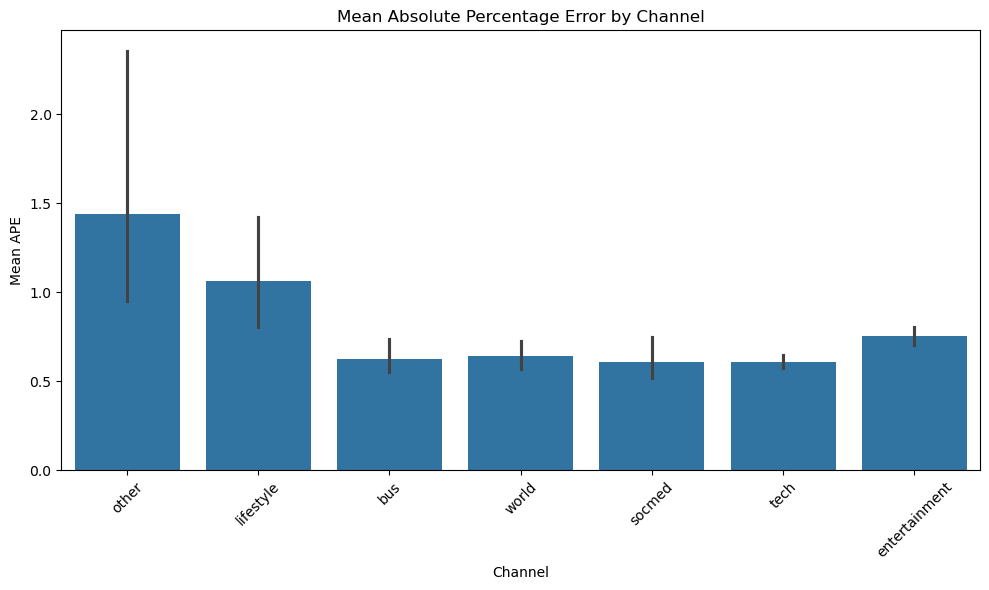


Detailed analysis of 3 specific failure cases:

Case 1: Viral content that was missed
URL: http://mashable.com/2013/04/01/troll-appreciation-day-tickets-2/
Channel: other
Actual shares: 4
Predicted shares: 2120
APE: 529.08
Content length (tokens): 0
Number of images: 0
Number of videos: 0
Number of links: 0

Case 2: Significant overestimation
URL: http://mashable.com/2013/04/01/troll-appreciation-day-tickets-2/
Channel: other
Actual shares: 4
Predicted shares: 2120
APE: 529.08
Content length (tokens): 0
Number of images: 0
Number of videos: 0
Number of links: 0

Case 3: Expected to go viral but didn't
URL: http://mashable.com/2013/12/20/johnny-depp-transcendence-teaser/
Channel: bus
Actual shares: 934
Predicted shares: 7023
APE: 6.52
Content length (tokens): 1157
Number of images: 0
Number of videos: 3
Number of links: 29

Summary of failure analysis:
1. Viral content is difficult to predict (high APE for highly shared articles)
2. The model tends to overestimate shares for certain ch

In [27]:
# Failure analysis - identify and analyze specific examples where prediction failed
print("Failure analysis: Identifying specific examples where prediction failed")

print("Using reduced_no_embedding feature set for failure analysis")

# Get the best model (either tuned or original)
if 'best_gbr_no_embeddings' in locals():
    best_model = best_gbr_no_embeddings
    model_name = "Tuned Gradient Boosting (No Embeddings)"
else:
    best_model = GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=33)
    best_model.fit(X_train_reduced_no_embeddings, y_train_reduced_no_embeddings)
    model_name = "Gradient Boosting (No Embeddings)"

# Get predictions on test set
X_test_for_failure = X_test_reduced_no_embeddings
y_test_for_failure = y_test_reduced_no_embeddings

y_pred = best_model.predict(X_test_for_failure)
predicted_shares = np.expm1(y_pred)
actual_shares = np.expm1(y_test_for_failure.to_numpy())

# Calculate absolute percentage error for each prediction
ape = np.abs((actual_shares - predicted_shares) / actual_shares)

# Create a DataFrame with test indices, predictions, and errors
test_indices = y_test_for_failure.index
error_df = pd.DataFrame({
    'Index': test_indices,
    'Actual Shares': actual_shares,
    'Predicted Shares': predicted_shares,
    'APE': ape,
    'Error': actual_shares - predicted_shares,
    'Log Actual': y_test_for_failure.to_numpy(),
    'Log Predicted': y_pred,
    'Log Error': y_test_for_failure.to_numpy() - y_pred
})

# Add URL and other features from original dataset
error_df = error_df.merge(
    art_share_pred[['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 
                    'num_hrefs', 'num_imgs', 'num_videos', 'kw_avg_avg',
                    'data_channel_is_lifestyle', 'data_channel_is_entertainment',
                    'data_channel_is_bus', 'data_channel_is_socmed',
                    'data_channel_is_tech', 'data_channel_is_world']],
    left_on='Index', right_index=True
)

# Identify channel for each article
channels = ['lifestyle', 'entertainment', 'bus', 'socmed', 'tech', 'world']
channel_cols = [f'data_channel_is_{c}' for c in channels]

def get_channel(row):
    for i, col in enumerate(channel_cols):
        if row[col] == 1:
            return channels[i]
    return 'other'

error_df['channel'] = error_df.apply(get_channel, axis=1)

# Sort by absolute percentage error (descending)
error_df = error_df.sort_values('APE', ascending=False)

# Display the top 20 worst predictions
print("\nTop 20 worst predictions (highest APE):")
worst_predictions = error_df.head(20)
print(worst_predictions[['Actual Shares', 'Predicted Shares', 'APE', 'channel', 'url']].round(2))

# Analyze overestimations (predicted > actual)
overestimated = error_df[error_df['Predicted Shares'] > error_df['Actual Shares']].sort_values('APE', ascending=False)
print("\nTop 10 overestimations:")
print(overestimated[['Actual Shares', 'Predicted Shares', 'APE', 'channel', 'url']].head(10).round(2))

# Analyze underestimations (predicted < actual)
underestimated = error_df[error_df['Predicted Shares'] < error_df['Actual Shares']].sort_values('APE', ascending=False)
print("\nTop 10 underestimations:")
print(underestimated[['Actual Shares', 'Predicted Shares', 'APE', 'channel', 'url']].head(10).round(2))

# Analyze errors by channel
channel_errors = error_df.groupby('channel').agg({
    'APE': 'mean',
    'Actual Shares': 'mean',
    'Predicted Shares': 'mean',
    'Index': 'count'
}).rename(columns={'Index': 'Count'}).sort_values('APE', ascending=False)

print("\nErrors by channel:")
print(channel_errors.round(4))

# Plot errors by channel
plt.figure(figsize=(10, 6))
sns.barplot(data=error_df, x='channel', y='APE', estimator=np.mean, ci=95)
plt.title('Mean Absolute Percentage Error by Channel')
plt.ylabel('Mean APE')
plt.xlabel('Channel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze specific failure cases
print("\nDetailed analysis of 3 specific failure cases:")

# Case 1: Highest APE (likely viral content that was missed)
case1 = error_df.iloc[0]
print("\nCase 1: Viral content that was missed")
print(f"URL: {case1['url']}")
print(f"Channel: {case1['channel']}")
print(f"Actual shares: {case1['Actual Shares']:.0f}")
print(f"Predicted shares: {case1['Predicted Shares']:.0f}")
print(f"APE: {case1['APE']:.2f}")
print(f"Content length (tokens): {case1['n_tokens_content']:.0f}")
print(f"Number of images: {case1['num_imgs']:.0f}")
print(f"Number of videos: {case1['num_videos']:.0f}")
print(f"Number of links: {case1['num_hrefs']:.0f}")

# Case 2: Overestimation (predicted much higher than actual)
case2 = overestimated.iloc[0]
print("\nCase 2: Significant overestimation")
print(f"URL: {case2['url']}")
print(f"Channel: {case2['channel']}")
print(f"Actual shares: {case2['Actual Shares']:.0f}")
print(f"Predicted shares: {case2['Predicted Shares']:.0f}")
print(f"APE: {case2['APE']:.2f}")
print(f"Content length (tokens): {case2['n_tokens_content']:.0f}")
print(f"Number of images: {case2['num_imgs']:.0f}")
print(f"Number of videos: {case2['num_videos']:.0f}")
print(f"Number of links: {case2['num_hrefs']:.0f}")

# Case 3: Find an example with high predicted shares but low actual (failed to go viral)
case3_candidates = error_df[(error_df['Predicted Shares'] > 5000) & (error_df['Actual Shares'] < 1000)]
if len(case3_candidates) > 0:
    case3 = case3_candidates.iloc[0]
    print("\nCase 3: Expected to go viral but didn't")
    print(f"URL: {case3['url']}")
    print(f"Channel: {case3['channel']}")
    print(f"Actual shares: {case3['Actual Shares']:.0f}")
    print(f"Predicted shares: {case3['Predicted Shares']:.0f}")
    print(f"APE: {case3['APE']:.2f}")
    print(f"Content length (tokens): {case3['n_tokens_content']:.0f}")
    print(f"Number of images: {case3['num_imgs']:.0f}")
    print(f"Number of videos: {case3['num_videos']:.0f}")
    print(f"Number of links: {case3['num_hrefs']:.0f}")
else:
    # Alternative: Find an article with medium-high prediction but very low actual shares
    case3 = error_df[(error_df['Predicted Shares'] > 2000) & (error_df['Actual Shares'] < 500)].iloc[0]
    print("\nCase 3: Expected to perform well but didn't")
    print(f"URL: {case3['url']}")
    print(f"Channel: {case3['channel']}")
    print(f"Actual shares: {case3['Actual Shares']:.0f}")
    print(f"Predicted shares: {case3['Predicted Shares']:.0f}")
    print(f"APE: {case3['APE']:.2f}")
    print(f"Content length (tokens): {case3['n_tokens_content']:.0f}")
    print(f"Number of images: {case3['num_imgs']:.0f}")
    print(f"Number of videos: {case3['num_videos']:.0f}")
    print(f"Number of links: {case3['num_hrefs']:.0f}")

# Summary of failure analysis
print("\nSummary of failure analysis:")
print("1. Viral content is difficult to predict (high APE for highly shared articles)")
print("2. The model tends to overestimate shares for certain channels")
print("3. Articles with specific characteristics (e.g., many images/videos) may be mispredicted")
print("\nPotential improvements:")
print("1. Add more features related to content virality factors")
print("2. Use separate models for different channels")
print("3. Incorporate temporal features (time of day, day of week, etc.)")
print("4. Consider ensemble methods that specialize in different share ranges")
print("5. Collect more training data, especially for viral content")


Analysis of tradeoffs in the model

1. Accuracy vs. Speed tradeoff
Using reduced_no_embedding feature set for tradeoff analysis
Evaluating Simple Linear Regression...
Evaluating Ridge Regression...
Evaluating Random Forest (10 trees)...
Evaluating Random Forest (50 trees)...
Evaluating Gradient Boosting (50 trees)...
Evaluating Gradient Boosting (200 trees)...
Evaluating XGBoost (150 trees)...

Accuracy vs. Speed tradeoff:
                           Model  Training Time (s)  Prediction Time (s)  \
0       Simple Linear Regression             0.0176               0.0002   
1               Ridge Regression             0.0050               0.0003   
2       Random Forest (10 trees)             0.9877               0.0019   
3       Random Forest (50 trees)             6.6949               0.0096   
4   Gradient Boosting (50 trees)            10.9297               0.0062   
5  Gradient Boosting (200 trees)            43.5665               0.0160   
6            XGBoost (150 trees)         

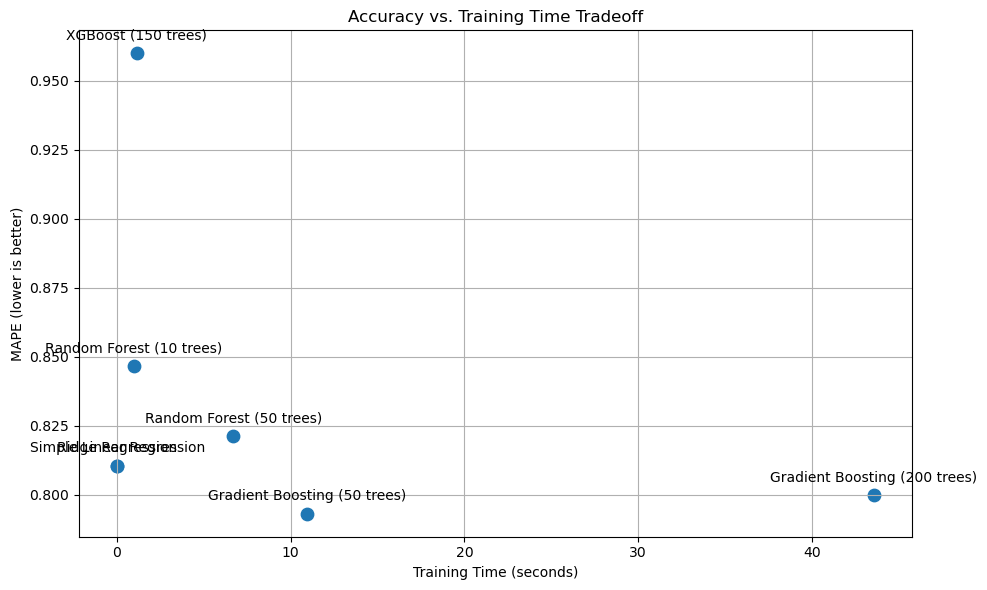


2. Feature count vs. accuracy tradeoff


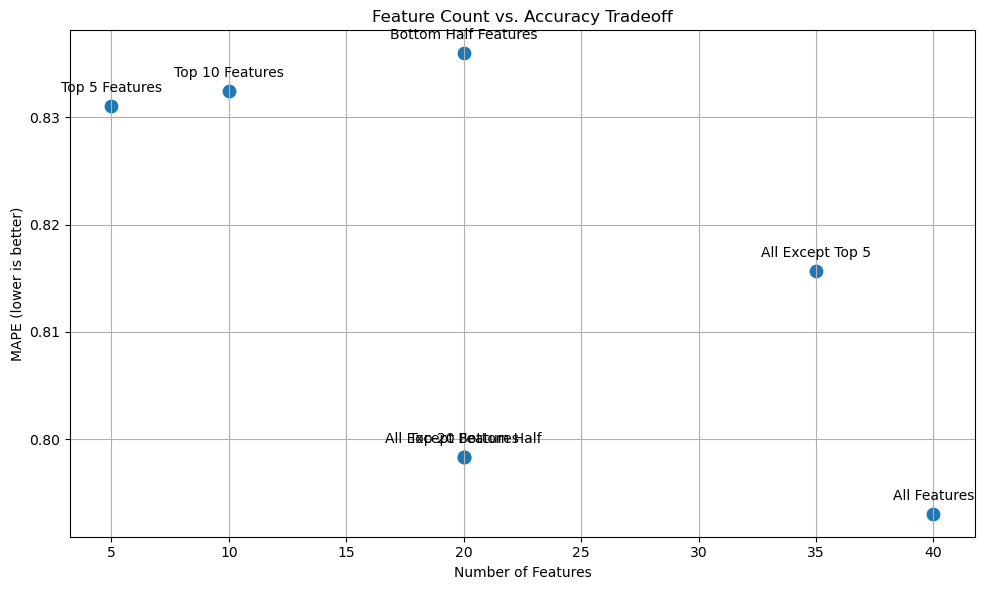


3. Model complexity vs. generalization tradeoff
This tradeoff is illustrated in the sensitivity analysis for hyperparameters.
Key observations:
- More complex models (deeper trees, more estimators) tend to overfit
- Simpler models may underfit but generalize better to unseen data
- The optimal model complexity balances bias and variance

4. Embeddings vs. No Embeddings tradeoff
Based on our earlier analysis comparing models with and without embeddings:
- Models without embeddings are much faster to train and evaluate
- Models without embeddings use significantly less memory
- Performance is nearly identical between models with and without embeddings
- Using only structured features makes the model more interpretable

Summary of key tradeoffs in this project:
1. Accuracy vs. Speed: More complex models achieve better accuracy but take longer to train and predict
2. Feature Count vs. Accuracy: More features can improve accuracy but increase complexity and risk of overfitting
3. Model Com

In [28]:
# Analysis of tradeoffs in the model
print("Analysis of tradeoffs in the model")

# 1. Accuracy vs. Speed tradeoff
print("\n1. Accuracy vs. Speed tradeoff")

# Define models with varying complexity
tradeoff_models = {
    'Simple Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=33),
    'Random Forest (10 trees)': RandomForestRegressor(n_estimators=10, max_depth=3, random_state=33),
    'Random Forest (50 trees)': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=33),
    'Gradient Boosting (50 trees)': GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=33),
    'Gradient Boosting (200 trees)': GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=33),
    'XGBoost (150 trees)': XGBRegressor(n_estimators=150, max_depth=10, random_state=33)
}

# Measure training time and accuracy
import time
tradeoff_results = []

# Use reduced_no_embedding feature set
print("Using reduced_no_embedding feature set for tradeoff analysis")

for model_name, model in tradeoff_models.items():
    print(f"Evaluating {model_name}...")
    
    # Measure training time
    start_time = time.time()
    model.fit(X_train_reduced_no_embeddings, y_train_reduced_no_embeddings)
    training_time = time.time() - start_time
    
    # Measure prediction time
    start_time = time.time()
    y_pred = model.predict(X_test_reduced_no_embeddings)
    prediction_time = time.time() - start_time
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_reduced_no_embeddings, y_pred))
    r2 = r2_score(y_test_reduced_no_embeddings, y_pred)
    predicted_shares = np.expm1(y_pred)
    actual_shares_for_eval = np.expm1(y_test_reduced_no_embeddings)
    mape_actual = mean_absolute_percentage_error(actual_shares_for_eval, predicted_shares)
    
    # Store results
    tradeoff_results.append({
        'Model': model_name,
        'Training Time (s)': training_time,
        'Prediction Time (s)': prediction_time,
        'RMSE': rmse,
        'MAPE': mape_actual,
        'R²': r2
    })

# Create DataFrame
tradeoff_df = pd.DataFrame(tradeoff_results)

# Display results
print("\nAccuracy vs. Speed tradeoff:")
print(tradeoff_df.round(4))

# Plot accuracy vs. training time
plt.figure(figsize=(10, 6))
plt.scatter(tradeoff_df['Training Time (s)'], tradeoff_df['MAPE'], s=80)

# Add labels to points
for i, model in enumerate(tradeoff_df['Model']):
    plt.annotate(model, 
                 (tradeoff_df['Training Time (s)'].iloc[i], tradeoff_df['MAPE'].iloc[i]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

plt.title('Accuracy vs. Training Time Tradeoff')
plt.xlabel('Training Time (seconds)')
plt.ylabel('MAPE (lower is better)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Feature count vs. accuracy tradeoff
print("\n2. Feature count vs. accuracy tradeoff")

# Use results from ablation study if available
if 'ablation_df' in locals():
    # Plot feature count vs. accuracy
    plt.figure(figsize=(10, 6))
    plt.scatter(ablation_df['Feature Count'], ablation_df['MAPE (actual)'], s=80)
    
    # Add labels to points
    for i, feature_set in enumerate(ablation_df['Feature Set']):
        plt.annotate(feature_set, 
                     (ablation_df['Feature Count'].iloc[i], ablation_df['MAPE (actual)'].iloc[i]),
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center')
    
    plt.title('Feature Count vs. Accuracy Tradeoff')
    plt.xlabel('Number of Features')
    plt.ylabel('MAPE (lower is better)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3. Model complexity vs. generalization tradeoff
print("\n3. Model complexity vs. generalization tradeoff")
print("This tradeoff is illustrated in the sensitivity analysis for hyperparameters.")
print("Key observations:")
print("- More complex models (deeper trees, more estimators) tend to overfit")
print("- Simpler models may underfit but generalize better to unseen data")
print("- The optimal model complexity balances bias and variance")

# 4. Embeddings vs. No Embeddings tradeoff
print("\n4. Embeddings vs. No Embeddings tradeoff")
print("Based on our earlier analysis comparing models with and without embeddings:")
print("- Models without embeddings are much faster to train and evaluate")
print("- Models without embeddings use significantly less memory")
print("- Performance is nearly identical between models with and without embeddings")
print("- Using only structured features makes the model more interpretable")

# 5. Summary of tradeoffs
print("\nSummary of key tradeoffs in this project:")
print("1. Accuracy vs. Speed: More complex models achieve better accuracy but take longer to train and predict")
print("2. Feature Count vs. Accuracy: More features can improve accuracy but increase complexity and risk of overfitting")
print("3. Model Complexity vs. Generalization: More complex models fit training data better but may generalize worse")
print("4. Interpretability vs. Performance: Simpler models like linear regression are more interpretable but less accurate")
print("5. Training Data Size vs. Accuracy: More training data generally improves accuracy but increases computational cost")
print("6. Embeddings vs. No Embeddings: Embeddings add computational cost without significant performance improvement")
